In [1]:
import os
import sys
import pickle
import string

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

from utils import *
from AnalyseDefects import AnalyseDefects

plt.style.use('sg_article')

In [2]:
def gen_analysis_dict(LL, mode):

    dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05', \
              suffix = "short", priority = -1, LX = LL, Nframes = 181)
    dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_long', \
                suffix = "long", priority = 1, LX = LL, Nframes = 400)
    dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long',\
                    suffix = "very_long", priority = 2, LX = LL, Nframes = 1500)
    dvery_long2 = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long_v2',\
                    suffix = "very_long2", priority = 3, LX = LL, Nframes = 1500)

    if mode == 'all':
        if LL == 2048:
            defect_list = [dshort, dlong]
        else:
            defect_list = [dshort, dlong, dvery_long, dvery_long2] if LL in [256] else [dshort, dlong, dvery_long]
    else:
        defect_list = [dshort]
    
    return defect_list

def extract_clp_results(clustering_dict, Nframes, Nexp, rmax_list, act_list, act_dir_list, save_path = None):
    """
    Analyse the defects for all the input folders
    """

    LX = clustering_dict['LX']
    suffix = clustering_dict['suffix']
    Nwindows = len(rmax_list)
    # create arrays to store the clustering data
    cluster_arr = np.nan * np.zeros([Nframes, Nwindows, 3, len(act_list), Nexp])
    
    for i, (act, act_dir) in enumerate(zip(act_list, act_dir_list)):

        exp_list = []
        exp_dir_list = []

        for file in os.listdir(act_dir):
            exp_count = file.split('_')[-1]
            exp_list.append(int(exp_count))
            exp_dir_list.append(os.path.join(act_dir, file))

        # sort the activity list and the activity directory list
        exp_list, exp_dir_list = zip(*sorted(zip(exp_list, exp_dir_list)))

        for j, (exp, exp_dir) in enumerate(zip(exp_list, exp_dir_list)):
            cl_res = np.load(os.path.join(exp_dir, 'cl_arr.npy'))[-Nframes:]
            cluster_arr[:,:cl_res.shape[1],:,i,j] = cl_res

    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, f'arr{suffix}.npy'), cluster_arr)
    return cluster_arr

def extract_clp_results_single(clustering_dict, act_dir_list, save_path = None):
    """
    Analyse the defects for all the input folders
    """

    suffix = clustering_dict['suffix']
    Nframes = clustering_dict['Nframes']
  

    # create arrays to store the clustering data
    cluster_arr = np.nan * np.zeros([Nframes, clustering_dict['Nwindows'], 3, clustering_dict['Nact'],])
    
    for i, act_dir in enumerate(act_dir_list):
        cl_res = np.load(os.path.join(act_dir, 'cl_arr.npy'))[-Nframes:]
        cluster_arr[:,:cl_res.shape[1],:,i] = cl_res


    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, f'arr{suffix}.npy'), cluster_arr)
    return cluster_arr

def get_defect_arr_from_frame(defect_dict, return_charge = False):
    """
    Convert dictionary of defects to array of defect positions
    Parameters:
    -----------
    defect_dict : dict
        Dictionary of defects positions and charges
    return_charge : bool
        If True, return defect charges as well

    Returns:
    --------
    defect_positions : np.ndarray
        Array of defect positions
    defect_charges : np.ndarray
    """

    Ndefects = len(defect_dict)
    if Ndefects == 0:
        return None
    
    defect_positions = np.empty([Ndefects, 3 if return_charge else 2])

    for i, defect in enumerate(defect_dict):
        defect_positions[i] = *defect['pos'], defect['charge'] if return_charge else defect['pos']
    return defect_positions

def get_clustering_signed(top_defect_list, method, rmax_list, method_kwargs, save = False, save_path = None):
    """
    
    Parameters:
    -----------
    Returns:
    --------
    """
  
    Nframes = len(top_defect_list)
    Nwindows = len(rmax_list)

    cl_arr = np.nan * np.ones([Nframes, Nwindows, 3])
   
    for frame, defects in enumerate(top_defect_list):
        # Get defect array for frame
        defect_arr = get_defect_arr_from_frame(defects, return_charge = True)
        defect_positions = defect_arr[:, :-1]
        defect_charges = defect_arr[:, -1] 

        if defect_positions is None:
            continue

        for i, rmax in enumerate(rmax_list):
            cst = method(distance_threshold = rmax, **method_kwargs)
            labels = cst.fit_predict(defect_positions)

            Ncl = np.max(labels) + 1
            Qc_arr = np.zeros(Ncl)

            for N in range(Ncl):
                mask = (labels == N)
                Qc = np.sum(defect_charges[mask])
                Qc_arr[N] = Qc
 
            all_neutral = float(np.all(Qc_arr == 0))
            Qcl = np.sum(np.abs(Qc_arr)) / Ncl
            cl_arr[frame, i] = [Ncl, Qcl, all_neutral]

    if save:
        # save labels list
        save_path = save_path if save_path is not None else 'labels_list.pkl'
        np.save(save_path, cl_arr)
    return cl_arr

def arg_func(arr, r_max_list, cutoff):
    if np.any(arr == cutoff):
        return r_max_list[np.argwhere(arr == cutoff)[0][0]]
    else:
        return -1
    
def arg_func_idx(arr, cutoff):
    if np.any(arr == cutoff):
        return np.argwhere(arr == cutoff)[0][0]
    else:
        return -1

def arg_func2(arr, cutoff):
    if np.any(arr == cutoff):
        return arr[np.argwhere(arr == cutoff)[0][0]]
    else:
        return -1
    
def get_defect_density(defect_list, area, return_charges=False, save_path = None,):
        """
        Get defect density for each frame in archive
        parameters:
            defect_list: list of lists of dictionaries holding defect charge and position for each frame 
            area: Area of system
            return_charges: if True, return list of densities of positive and negative defects
        returns:
            dens_defects: array of defect densities (Nframes, 3) if return_charges is True else (Nframes, 2)
        """

        if return_charges:
            # Initialize list of defect densities
            dens_pos_defects = []
            dens_neg_defects = []
            for defects in defect_list:
                # Get no. of defects
                nposdef = len([d for d in defects if d['charge'] == 0.5])
                nnegdef = len([d for d in defects if d['charge'] == -0.5])

                dens_pos_defects.append(nposdef / area)
                dens_neg_defects.append(nnegdef / area)

            if save_path is not None:
                np.savetxt(save_path + '_pos', dens_pos_defects)
                np.savetxt(save_path + '_neg', dens_neg_defects)
            return dens_pos_defects, dens_neg_defects
        else:
            dens_defects = []
            for defects in defect_list:
                # Get no. of defects
                ndef = len(defects)
                dens_defects.append(ndef / area)
            if save_path is not None:
                np.savetxt(save_path, dens_defects)
            return dens_defects


In [3]:
LX = 256
mode = 'wet'

lambda_list = [0]#, 0.1, 0.5, 0.8]

extract = False
find_conv = False
analyze= True
analyze_per_frame = True #if mode == 'dry' else False
plot_figs = True
save_figs = True

for lambda_val in lambda_list:
    base_path_fwd = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\jayeeta\\diff_lambda\\{mode}\\na{LX}\\{lambda_val}\\fwd'
    base_path_bck = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\jayeeta\\diff_lambda\\{mode}\\na{LX}\\{lambda_val}\\bck'
    out_path = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda\\{mode}\\na{LX}\\{lambda_val}'
    fig_path = os.path.join(out_path, 'figs')

    if not os.path.isdir(fig_path):
        os.makedirs(fig_path)
    if not os.path.isdir(out_path):
        os.makedirs(out_path)

    print(f'Analyzing {mode} with lambda = {lambda_val}')
    t1 = time.perf_counter()    

    act_dirs_fwd = [os.path.join(base_path_fwd, x) for x in os.listdir(base_path_fwd)]
    act_dirs_bck = [os.path.join(base_path_bck, x) for x in os.listdir(base_path_bck)] 

    act_fwd = [float(x.split('-')[-2]) for x in os.listdir(base_path_fwd)]
    act_bck = [float(x.split('-')[-2]) for x in os.listdir(base_path_bck)]

    act_exclude_fwd = []
    act_exclude_bck = []

    Nact_fwd = len(act_fwd)
    Nact_bck = len(act_bck)

    rmax_list = np.arange(10, LX / 2) if mode == 'wet' and LX==512 else np.arange(1, LX / 2,)
    Nframes = 51
    Nwindows = len(rmax_list)
    ninfo = 1000

    cluster_dict_fwd = dict(LX = LX, Nframes = Nframes, Nact = len(act_fwd), Nwindows = len(rmax_list), path = out_path, suffix = '_fwd')
    cluster_dict_bck = dict(LX = LX, Nframes = Nframes, Nact = len(act_bck), Nwindows = len(rmax_list), path = out_path, suffix = '_bck')

    if extract:
        clp_arr_fwd = extract_clp_results_single(cluster_dict_fwd, act_dirs_fwd, save_path=out_path)
        clp_arr_bck = extract_clp_results_single(cluster_dict_bck, act_dirs_bck, save_path=out_path)

        def_arr_fwd = np.zeros([Nframes, Nact_fwd])
        def_arr_bck = np.zeros([Nframes, Nact_bck])

        for i, (act_dir_list, arr) in enumerate(zip([act_dirs_fwd, act_dirs_bck], [def_arr_fwd, def_arr_bck])):
            
            for j, act_dir in enumerate(act_dir_list):
                path = os.path.join(act_dir, 'defect_positions.pkl')
                with open(path, 'rb') as f:
                    defect_dict = pickle.load(f)
                def_list_pos = get_defect_density(defect_dict, area = 1)
                arr[:, j] = def_list_pos

        # save 
        np.save(os.path.join(out_path, 'def_arr_fwd.npy'), def_arr_fwd)
        np.save(os.path.join(out_path, 'def_arr_bck.npy'), def_arr_bck)

    else:
        clp_arr_fwd = np.load(os.path.join(out_path, 'arr_fwd.npy'))
        clp_arr_bck = np.load(os.path.join(out_path, 'arr_bck.npy'))

        def_arr_fwd = np.load(os.path.join(out_path, 'def_arr_fwd.npy'))
        def_arr_bck = np.load(os.path.join(out_path, 'def_arr_bck.npy'))

        if not find_conv:
            conv_list_bck = np.load(os.path.join(out_path, 'conv_list_bck.npy'))
            conv_list_fwd = np.load(os.path.join(out_path, 'conv_list_fwd.npy'))

Analyzing wet with lambda = 0


In [5]:

if analyze:
    uncertainty_multiplier = 5
    ncutoff_frac_lower = .05
    qpeak_idx_min = 3
    actm_filter_fwd = 0.23 if mode == 'dry' else 0.08
    actm_filter_bck = 0.23 if mode == 'dry' else 0.08
    act_min_lneutral_fwd = 0.005
    act_min_lneutral_bck = 0.0
    replace_shifted = False #True if mode == 'dry' else False

    arg_func1d = lambda arr: arg_func(arr, rmax_list, cutoff = 1)

    lmax_arr_fwd = np.apply_along_axis(arg_func1d, axis=1, arr=clp_arr_fwd[:, :, -1, :,])
    lmax_arr_bck = np.apply_along_axis(arg_func1d, axis=1, arr=clp_arr_bck[:, :, -1, :,])

    lperc_arr_fwd = np.apply_along_axis(arg_func1d, axis=1, arr=clp_arr_fwd[:, :, 0, :,])
    lperc_arr_bck = np.apply_along_axis(arg_func1d, axis=1, arr=clp_arr_bck[:, :, 0, :,])

    idx_arr_fwd = np.apply_along_axis(lambda arr: arg_func_idx(arr, cutoff = 1), axis=1, arr=clp_arr_fwd[:, :, 0, :,])
    idx_arr_bck = np.apply_along_axis(lambda arr: arg_func_idx(arr, cutoff = 1), axis=1, arr=clp_arr_bck[:, :, 0, :,])

    qmax_arr_fwd = np.nan * np.zeros_like(idx_arr_fwd)
    qmax_arr_bck = np.nan * np.zeros_like(idx_arr_bck)

    lmax_av_fwd = np.nan * np.zeros((len(act_fwd), 2))
    lmax_av_bck = np.nan * np.zeros((len(act_bck), 2))
    lperc_av_fwd = np.nan * np.zeros((len(act_fwd), 2))
    lperc_av_bck = np.nan * np.zeros((len(act_bck), 2))

    qarr_shifted_fwd = np.nan * np.zeros((Nframes, len(rmax_list), len(act_fwd)))
    qarr_shifted_bck = np.nan * np.zeros((Nframes, len(rmax_list), len(act_bck)))

    q_av_fwd = np.nan * np.zeros((len(act_fwd), len(rmax_list), 2))
    q_av_bck = np.nan * np.zeros((len(act_bck), len(rmax_list), 2))
    qfilter_fwd = np.zeros((len(act_fwd), len(rmax_list),2))   
    qfilter_bck = np.zeros((len(act_bck), len(rmax_list),2))

    qpeak_fwd = np.nan * np.zeros((len(act_fwd), 2))
    qpeak_bck = np.nan * np.zeros((len(act_bck), 2))
    lneutral_fwd = np.nan * np.zeros((len(act_fwd), 2))
    lneutral_bck = np.nan * np.zeros((len(act_bck), 2))

    qpeak_filter_fwd = np.nan * np.zeros((len(act_fwd),2))
    qpeak_filter_bck = np.nan * np.zeros((len(act_bck),2))
    lneutral_filter_fwd = np.nan * np.zeros((len(act_fwd),2)) 
    lneutral_filter_bck = np.nan * np.zeros((len(act_bck),2))

    lneutral_per_frame_fwd = np.nan * np.zeros((Nact_fwd, 2)) 
    lneutral_per_frame_bck = np.nan * np.zeros((Nact_bck, 2))
    qpeak_per_frame_fwd = np.nan * np.zeros((Nact_fwd, 2))    
    qpeak_per_frame_bck = np.nan * np.zeros((Nact_bck, 2))

    for i, _ in enumerate(act_fwd):
        ff_idx = int(conv_list_fwd[i])

        mask = (lmax_arr_fwd[ff_idx:, i,] > 0)
        nsamples = mask.sum()
        if nsamples / lmax_arr_fwd[ff_idx:, i,].size > ncutoff_frac_lower:
            arr_res = lmax_arr_fwd[ff_idx:, i,][mask]
            lmax_av_fwd[i,0] = np.nanmean(arr_res)
            lmax_av_fwd[i,1] = np.nanstd(arr_res, ddof = 1,) / np.sqrt(nsamples / uncertainty_multiplier)


        mask_perc = (lperc_arr_fwd[ff_idx:, i,] > 0)
        nsamples_perc = mask_perc.sum()
        if nsamples_perc / lperc_arr_fwd[ff_idx:, i,].size > ncutoff_frac_lower:
            arr_res_perc = lperc_arr_fwd[ff_idx:, i,][mask_perc]
            lperc_av_fwd[i,0] = np.nanmean(arr_res_perc)
            lperc_av_fwd[i,1] = np.nanstd(arr_res_perc, ddof = 1,) / np.sqrt(nsamples_perc / uncertainty_multiplier)

        for f in range(ff_idx, Nframes):
                
                arr_idx = idx_arr_fwd[f, i]
                qmax_arr_fwd[f, i] = clp_arr_fwd[f, arr_idx, 1, i,]  #np.diag(clp_arr_fwd[f, arr_idx, 1, i,])

    for i, _ in enumerate(act_bck):
        ff_idx = int(conv_list_bck[i])

        mask = (lmax_arr_bck[ff_idx:, i,] > 0)
        nsamples = mask.sum()
        if nsamples / lmax_arr_bck[ff_idx:, i,].size > ncutoff_frac_lower:
            arr_res = lmax_arr_bck[ff_idx:, i,][mask]
            lmax_av_bck[i,0] = np.nanmean(arr_res)
            lmax_av_bck[i,1] = np.nanstd(arr_res, ddof = 1,) / np.sqrt(nsamples / uncertainty_multiplier)

        mask_perc = (lperc_arr_bck[ff_idx:, i,] > 0)
        nsamples_perc = mask_perc.sum()
        if nsamples_perc / lperc_arr_bck[ff_idx:, i,].size > ncutoff_frac_lower:
            arr_res_perc = lperc_arr_bck[ff_idx:, i,][mask_perc]
            lperc_av_bck[i,0] = np.nanmean(arr_res_perc)
            lperc_av_bck[i,1] = np.nanstd(arr_res_perc, ddof = 1,) / np.sqrt(nsamples_perc / uncertainty_multiplier)

        for f in range(ff_idx, Nframes):
                
                arr_idx = idx_arr_bck[f, i]
                qmax_arr_bck[f, i] = clp_arr_bck[f, arr_idx, 1, i,]  #np.diag(clp_arr_fwd[f, arr_idx, 1, i,])
        
    for i, act in enumerate(act_fwd):
        qarr_shifted_fwd[:,:, i] = clp_arr_fwd[:, :, 1, i] - qmax_arr_fwd[:,i][:, None] / clp_arr_fwd[:, :, 0, i]
    for i, act in enumerate(act_bck):
        qarr_shifted_bck[:,:, i] = clp_arr_bck[:, :, 1, i] - qmax_arr_bck[:,i][:, None] / clp_arr_bck[:, :, 0, i]

    # replace nan values with 0
    np.nan_to_num(qarr_shifted_fwd, copy = False)
    np.nan_to_num(qarr_shifted_bck, copy = False)


    for i, act in enumerate(act_fwd):
        ff_idx = int(conv_list_fwd[i])
        nsamples = qarr_shifted_fwd[ff_idx:, :, i,].shape[0]
        q_av_fwd[i, :, 0] = np.nanmean(qarr_shifted_fwd[ff_idx:, :, i,], axis=(0,))
        q_av_fwd[i, :, 1] = np.nanstd(qarr_shifted_fwd[ff_idx:, :, i,], axis=(0,)) \
        / np.sqrt(nsamples / uncertainty_multiplier)

        filter = (qmax_arr_fwd[ff_idx:,i] == 0)
        nsamples_filter = filter.sum()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            vals = clp_arr_fwd[ff_idx:, :, 1, i]
            np.nan_to_num(vals, copy = False)
            qfilter_fwd[i, :, 0] = np.nanmean(vals, axis = 0)
            qfilter_fwd[i, :, 1] = np.nanstd(vals, axis = 0) \
                / np.sqrt(nsamples_filter / uncertainty_multiplier)

    for i, act in enumerate(act_bck):
        ff_idx = int(conv_list_bck[i])
        nsamples = qarr_shifted_bck[ff_idx:, :, i,].shape[0]
        q_av_bck[i, :, 0] = np.nanmean(qarr_shifted_bck[ff_idx:, :, i,], axis=(0,))
        q_av_bck[i, :, 1] = np.nanstd(qarr_shifted_bck[ff_idx:, :, i,], axis=(0,)) \
        / np.sqrt(nsamples / uncertainty_multiplier)

        filter = (qmax_arr_bck[ff_idx:,i] == 0)
        nsamples_filter = filter.sum()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            vals = clp_arr_bck[ff_idx:, :, 1, i]
            np.nan_to_num(vals, copy = False)

            qfilter_bck[i, :, 0] = np.nanmean(vals, axis = 0)
            qfilter_bck[i, :, 1] = np.nanstd(vals, axis = 0) \
                / np.sqrt(nsamples_filter / uncertainty_multiplier)

    for i, act in enumerate(act_fwd):
        if act <= act_min_lneutral_fwd:
            continue
        if np.allclose(def_arr_fwd[:,i], 0):
                continue

        arg_neutral_lower = np.argwhere(q_av_fwd[i, :, 0]-q_av_fwd[i, :, 1] <= 0)
        if len(arg_neutral_lower) > 0:
            idx_neutral = arg_neutral_lower[0][0]

            lneutral_fwd[i,0] = rmax_list[int(idx_neutral)] 
            lneutral_fwd[i,1] = np.diff(rmax_list)[0] / 2
        else:
            idx_neutral = np.nan

        idx_max = np.argmax(q_av_fwd[i, qpeak_idx_min:, 0]-q_av_fwd[i, qpeak_idx_min:, 1])
        if not idx_max + qpeak_idx_min > idx_neutral:
            qpeak_fwd[i,0] =  rmax_list[idx_max + qpeak_idx_min]# qfilter_bck[i, idx_max + qpeak_idx_min]
            qpeak_fwd[i,1] = np.diff(rmax_list)[0] / 2


        # repeat for filter
        ff_idx = int(conv_list_fwd[i])
        if act > actm_filter_fwd:
            continue

        arg_neutral_lower = np.argwhere(qfilter_fwd[i, :, 0]-qfilter_fwd[i, :, 1] <= 0)
        if len(arg_neutral_lower) > 0:
            idx_neutral = arg_neutral_lower[0][0]

            lneutral_filter_fwd[i,0] = rmax_list[int(idx_neutral)] 
            lneutral_filter_fwd[i,1] = np.diff(rmax_list)[0] / 2
        else:
            idx_neutral = np.nan

        idx_max = np.argmax(qfilter_fwd[i, qpeak_idx_min:, 0]-qfilter_fwd[i, qpeak_idx_min:, 1])
        if not idx_max + qpeak_idx_min > idx_neutral:
            qpeak_filter_fwd[i,0] =  rmax_list[idx_max + qpeak_idx_min]# qfilter_bck[i, idx_max + qpeak_idx_min]
            qpeak_filter_fwd[i,1] = np.diff(rmax_list)[0] / 2


    
    for i, act in enumerate(act_bck):
        if act <= act_min_lneutral_bck:
            continue
        if np.allclose(def_arr_bck[:,i], 0):
                continue

        arg_neutral_lower = np.argwhere(q_av_bck[i, :, 0]-q_av_bck[i, :, 1] <= 0)
        if len(arg_neutral_lower) > 0:
            idx_neutral = arg_neutral_lower[0][0]

            lneutral_bck[i,0] = rmax_list[int(idx_neutral)] 
            lneutral_bck[i,1] = np.diff(rmax_list)[0] / 2
        else:  
            idx_neutral = np.nan

        idx_max = np.argmax(q_av_bck[i, qpeak_idx_min:, 0]-q_av_bck[i, qpeak_idx_min:, 1])
        if not idx_max + qpeak_idx_min > idx_neutral:
            qpeak_bck[i,0] =  rmax_list[idx_max + qpeak_idx_min]# qfilter_bck[i, idx_max + qpeak_idx_min]
            qpeak_bck[i,1] = np.diff(rmax_list)[0] / 2


    
        # repeat for filter
        ff_idx = int(conv_list_bck[i])
        if act > actm_filter_bck:
            continue

        arg_neutral_lower = np.argwhere(qfilter_bck[i, :, 0]-qfilter_bck[i, :, 1] <= 0)
        if len(arg_neutral_lower) > 0:
            idx_neutral = arg_neutral_lower[0][0]

            lneutral_filter_bck[i,0] = rmax_list[int(idx_neutral)] 
            lneutral_filter_bck[i,1] = np.diff(rmax_list)[0] / 2
        else:
            idx_neutral = np.nan

        idx_max = np.argmax(qfilter_bck[i, qpeak_idx_min:, 0]-qfilter_bck[i, qpeak_idx_min:, 1])
        if not idx_max + qpeak_idx_min > idx_neutral:
            qpeak_filter_bck[i,0] =  rmax_list[idx_max + qpeak_idx_min]# qfilter_bck[i, idx_max + qpeak_idx_min]
            qpeak_filter_bck[i,1] = np.diff(rmax_list)[0] / 2
        
        
    if replace_shifted:
        mask_bck = lneutral_filter_bck[:,0] > 0
        mask_fwd = lneutral_filter_fwd[:,0] > 0
        lneutral_bck[mask_bck,0] = lneutral_filter_bck[mask_bck,0]
        lneutral_fwd[mask_fwd,0] = lneutral_filter_fwd[mask_fwd,0]

    if analyze_per_frame:
        for j, act in enumerate(act_fwd):

            if np.allclose(def_arr_fwd[:,j], 0):
                continue

            vals = clp_arr_fwd[:, :, 1, j]  
            filter = (qmax_arr_fwd[:,j] == 0)
            vals = vals[filter]
            lm_list = []
            qp_list = []
            for i in range(vals.shape[0]):
                lm_list.append(np.argwhere(vals[i,:]==0)[0][0])
                qp_list.append(rmax_list[np.argmax(vals[i,qpeak_idx_min:]) + qpeak_idx_min])
            #  print(np.argmax(vals[i,qpeak_idx_min:]) + qpeak_idx_min)
            if len(lm_list) > 2:
                lneutral_per_frame_fwd[j,0] = np.mean(lm_list)
                lneutral_per_frame_fwd[j,1] = np.std(lm_list, ddof = 1) / np.sqrt(len(lm_list) / uncertainty_multiplier)
            if len(qp_list) > 2:
                qpeak_per_frame_fwd[j,0] = np.mean(qp_list)
                qpeak_per_frame_fwd[j,1] = np.std(qp_list, ddof = 1) / np.sqrt(len(qp_list) / uncertainty_multiplier)

        for j, act in enumerate(act_bck):

            if np.allclose(def_arr_bck[:,j], 0):
                continue

            vals = clp_arr_bck[:, :, 1, j]  
            filter = (qmax_arr_bck[:,j] == 0)
            vals = vals[filter]
            lm_list = []
            qp_list = []
            for i in range(vals.shape[0]):
                lm_list.append(np.argwhere(vals[i]==0)[0][0])
                qp_list.append(rmax_list[np.argmax(vals[i,qpeak_idx_min:]) + qpeak_idx_min])
            if len(lm_list) > 2:
                lneutral_per_frame_bck[j,0] = np.mean(lm_list)
                lneutral_per_frame_bck[j,1] = np.std(lm_list, ddof = 1) / np.sqrt(len(lm_list) / uncertainty_multiplier)
            if len(qp_list) > 2:
                qpeak_per_frame_bck[j,0] = np.mean(qp_list)
                qpeak_per_frame_bck[j,1] = np.std(qp_list, ddof = 1) / np.sqrt(len(qp_list) / uncertainty_multiplier)

        # save data
        np.save(os.path.join(out_path, 'lneutral_per_frame_fwd.npy'), lneutral_per_frame_fwd)
        np.save(os.path.join(out_path, 'lneutral_per_frame_bck.npy'), lneutral_per_frame_bck)
        np.save(os.path.join(out_path, 'qpeak_per_frame_fwd.npy'), qpeak_per_frame_fwd)
        np.save(os.path.join(out_path, 'qpeak_per_frame_bck.npy'), qpeak_per_frame_bck)

    np.save(os.path.join(out_path, 'lmax_fwd.npy'), lmax_av_fwd)
    np.save(os.path.join(out_path, 'lmax_bck.npy'), lmax_av_bck)
    np.save(os.path.join(out_path, 'lperc_fwd.npy'), lperc_av_fwd)
    np.save(os.path.join(out_path, 'lperc_bck.npy'), lperc_av_bck)

    np.save(os.path.join(out_path, 'qmax_arr_fwd.npy'), qmax_arr_fwd)
    np.save(os.path.join(out_path, 'qmax_arr_bck.npy'), qmax_arr_bck)
    np.save(os.path.join(out_path, 'qarr_shifted_fwd.npy'), qarr_shifted_fwd)
    np.save(os.path.join(out_path, 'qarr_shifted_bck.npy'), qarr_shifted_bck)

    np.save(os.path.join(out_path, 'q_av_fwd.npy'), q_av_fwd)
    np.save(os.path.join(out_path, 'q_av_bck.npy'), q_av_bck)
    np.save(os.path.join(out_path, 'qfilter_fwd.npy'), qfilter_fwd)
    np.save(os.path.join(out_path, 'qfilter_bck.npy'), qfilter_bck)

    np.save(os.path.join(out_path, 'qpeak_fwd.npy'), qpeak_fwd)
    np.save(os.path.join(out_path, 'qpeak_bck.npy'), qpeak_bck)
    np.save(os.path.join(out_path, 'lneutral_fwd.npy'), lneutral_fwd)
    np.save(os.path.join(out_path, 'lneutral_bck.npy'), lneutral_bck)
    np.save(os.path.join(out_path, 'qpeak_filter_fwd.npy'), qpeak_filter_fwd)
    np.save(os.path.join(out_path, 'qpeak_filter_bck.npy'), qpeak_filter_bck)
    np.save(os.path.join(out_path, 'lneutral_filter_fwd.npy'), lneutral_filter_fwd)
    np.save(os.path.join(out_path, 'lneutral_filter_bck.npy'), lneutral_filter_bck)



In [63]:
extract = False
save_figs = True

LX = 512
mode = 'dry'

defect_list = gen_analysis_dict(LX, mode)

fig_path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Figures\\passive'
base_path_fwd = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\jayeeta\\{mode}\\na{LX}\\fwd'
base_path_bck = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\jayeeta\\{mode}\\na{LX}\\bck'
out_path = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\{mode}\\na{LX}'

if not os.path.isdir(fig_path):
    os.makedirs(fig_path)
if not os.path.isdir(out_path):
    os.makedirs(out_path)


act_dirs_fwd = [os.path.join(base_path_fwd, x) for x in os.listdir(base_path_fwd)]
act_dirs_bck = [os.path.join(base_path_bck, x) for x in os.listdir(base_path_bck)] 

act_fwd = [float(x.split('-')[-2]) for x in os.listdir(base_path_fwd)]
act_bck = [float(x.split('-')[-2]) for x in os.listdir(base_path_bck)]

act_exclude_fwd = [0.006]
act_exclude_bck = []

Nact_fwd = len(act_fwd)
Nact_bck = len(act_bck)

rmax_list = np.arange(1, LX / 2) if mode == 'dry' else np.arange(10, LX / 2,)
Nframes = 51
Nwindows = len(rmax_list)
ninfo = 1000

cluster_dict_fwd = dict(LX = LX, Nframes = Nframes, Nact = len(act_fwd), Nwindows = len(rmax_list), path = out_path, suffix = '_fwd')
cluster_dict_bck = dict(LX = LX, Nframes = Nframes, Nact = len(act_bck), Nwindows = len(rmax_list), path = out_path, suffix = '_bck')

if extract:
    clp_arr_fwd = extract_clp_results_single(cluster_dict_fwd, act_dirs_fwd, save_path=out_path)
    clp_arr_bck = extract_clp_results_single(cluster_dict_bck, act_dirs_bck, save_path=out_path)

    def_arr_fwd = np.zeros([Nframes, Nact_fwd])
    def_arr_bck = np.zeros([Nframes, Nact_bck])

    for i, (act_dir_list, arr) in enumerate(zip([act_dirs_fwd, act_dirs_bck], [def_arr_fwd, def_arr_bck])):
        
        for j, act_dir in enumerate(act_dir_list):
            path = os.path.join(act_dir, 'defect_positions.pkl')
            with open(path, 'rb') as f:
                defect_dict = pickle.load(f)
            def_list_pos = get_defect_density(defect_dict, area = 1)
            arr[:, j] = def_list_pos

    # save 
    np.save(os.path.join(out_path, 'def_arr_fwd.npy'), def_arr_fwd)
    np.save(os.path.join(out_path, 'def_arr_bck.npy'), def_arr_bck)

else:
    clp_arr_fwd = np.load(os.path.join(out_path, 'arr_fwd.npy'))
    clp_arr_bck = np.load(os.path.join(out_path, 'arr_bck.npy'))

    def_arr_fwd = np.load(os.path.join(out_path, 'def_arr_fwd.npy'))
    def_arr_bck = np.load(os.path.join(out_path, 'def_arr_bck.npy'))

    conv_list_bck = np.load(os.path.join(out_path, 'conv_list_bck.npy'))
    conv_list_fwd = np.load(os.path.join(out_path, 'conv_list_fwd.npy'))



In [ ]:
uncertainty_multiplier = 5
ncutoff_frac_lower = .05
qpeak_idx_min = 3
actm_filter_fwd = 0.23
actm_filter_bck = 0.23
act_min_lneutral_fwd = 0.005
act_min_lneutral_bck = 0.0

arg_func1d = lambda arr: arg_func(arr, rmax_list, cutoff = 1)

lmax_arr_fwd = np.apply_along_axis(arg_func1d, axis=1, arr=clp_arr_fwd[:, :, -1, :,])
lmax_arr_bck = np.apply_along_axis(arg_func1d, axis=1, arr=clp_arr_bck[:, :, -1, :,])

lperc_arr_fwd = np.apply_along_axis(arg_func1d, axis=1, arr=clp_arr_fwd[:, :, 0, :,])
lperc_arr_bck = np.apply_along_axis(arg_func1d, axis=1, arr=clp_arr_bck[:, :, 0, :,])

idx_arr_fwd = np.apply_along_axis(lambda arr: arg_func_idx(arr, cutoff = 1), axis=1, arr=clp_arr_fwd[:, :, 0, :,])
idx_arr_bck = np.apply_along_axis(lambda arr: arg_func_idx(arr, cutoff = 1), axis=1, arr=clp_arr_bck[:, :, 0, :,])

qmax_arr_fwd = np.nan * np.zeros_like(idx_arr_fwd)
qmax_arr_bck = np.nan * np.zeros_like(idx_arr_bck)

lmax_av_fwd = np.nan * np.zeros((len(act_fwd), 2))
lmax_av_bck = np.nan * np.zeros((len(act_bck), 2))
lperc_av_fwd = np.nan * np.zeros((len(act_fwd), 2))
lperc_av_bck = np.nan * np.zeros((len(act_bck), 2))

qarr_shifted_fwd = np.nan * np.zeros((Nframes, len(rmax_list), len(act_fwd)))
qarr_shifted_bck = np.nan * np.zeros((Nframes, len(rmax_list), len(act_bck)))

q_av_fwd = np.nan * np.zeros((len(act_fwd), len(rmax_list), 2))
q_av_bck = np.nan * np.zeros((len(act_bck), len(rmax_list), 2))
qfilter_fwd = np.zeros((len(act_fwd), len(rmax_list),2))   
qfilter_bck = np.zeros((len(act_bck), len(rmax_list),2))

qpeak_fwd = np.nan * np.zeros((len(act_fwd), 2))
qpeak_bck = np.nan * np.zeros((len(act_bck), 2))
lneutral_fwd = np.nan * np.zeros((len(act_fwd), 2))
lneutral_bck = np.nan * np.zeros((len(act_bck), 2))

qpeak_filter_fwd = np.nan * np.zeros((len(act_fwd),2))
qpeak_filter_bck = np.nan * np.zeros((len(act_bck),2))
lneutral_filter_fwd = np.nan * np.zeros((len(act_fwd),2)) 
lneutral_filter_bck = np.nan * np.zeros((len(act_bck),2))

for i, _ in enumerate(act_fwd):
    ff_idx = int(conv_list_fwd[i])

    mask = (lmax_arr_fwd[ff_idx:, i,] > 0)
    nsamples = mask.sum()
    if nsamples / lmax_arr_fwd[ff_idx:, i,].size > ncutoff_frac_lower:
        arr_res = lmax_arr_fwd[ff_idx:, i,][mask]
        lmax_av_fwd[i,0] = np.nanmean(arr_res)
        lmax_av_fwd[i,1] = np.nanstd(arr_res, ddof = 1,) / np.sqrt(nsamples / uncertainty_multiplier)


    mask_perc = (lperc_arr_fwd[ff_idx:, i,] > 0)
    nsamples_perc = mask_perc.sum()
    if nsamples_perc / lperc_arr_fwd[ff_idx:, i,].size > ncutoff_frac_lower:
        arr_res_perc = lperc_arr_fwd[ff_idx:, i,][mask_perc]
        lperc_av_fwd[i,0] = np.nanmean(arr_res_perc)
        lperc_av_fwd[i,1] = np.nanstd(arr_res_perc, ddof = 1,) / np.sqrt(nsamples_perc / uncertainty_multiplier)

    for f in range(ff_idx, Nframes):
            
            arr_idx = idx_arr_fwd[f, i]
            qmax_arr_fwd[f, i] = clp_arr_fwd[f, arr_idx, 1, i,]  #np.diag(clp_arr_fwd[f, arr_idx, 1, i,])

for i, _ in enumerate(act_bck):
    ff_idx = int(conv_list_bck[i])

    mask = (lmax_arr_bck[ff_idx:, i,] > 0)
    nsamples = mask.sum()
    if nsamples / lmax_arr_bck[ff_idx:, i,].size > ncutoff_frac_lower:
        arr_res = lmax_arr_bck[ff_idx:, i,][mask]
        lmax_av_bck[i,0] = np.nanmean(arr_res)
        lmax_av_bck[i,1] = np.nanstd(arr_res, ddof = 1,) / np.sqrt(nsamples / uncertainty_multiplier)

    mask_perc = (lperc_arr_bck[ff_idx:, i,] > 0)
    nsamples_perc = mask_perc.sum()
    if nsamples_perc / lperc_arr_bck[ff_idx:, i,].size > ncutoff_frac_lower:
        arr_res_perc = lperc_arr_bck[ff_idx:, i,][mask_perc]
        lperc_av_bck[i,0] = np.nanmean(arr_res_perc)
        lperc_av_bck[i,1] = np.nanstd(arr_res_perc, ddof = 1,) / np.sqrt(nsamples_perc / uncertainty_multiplier)

    for f in range(ff_idx, Nframes):
            
            arr_idx = idx_arr_bck[f, i]
            qmax_arr_bck[f, i] = clp_arr_bck[f, arr_idx, 1, i,]  #np.diag(clp_arr_fwd[f, arr_idx, 1, i,])
     
for i, act in enumerate(act_fwd):
    qarr_shifted_fwd[:,:, i] = clp_arr_fwd[:, :, 1, i] - qmax_arr_fwd[:,i][:, None] / clp_arr_fwd[:, :, 0, i]
for i, act in enumerate(act_bck):
    qarr_shifted_bck[:,:, i] = clp_arr_bck[:, :, 1, i] - qmax_arr_bck[:,i][:, None] / clp_arr_bck[:, :, 0, i]

# replace nan values with 0
np.nan_to_num(qarr_shifted_fwd, copy = False)
np.nan_to_num(qarr_shifted_bck, copy = False)


for i, act in enumerate(act_fwd):
    ff_idx = int(conv_list_fwd[i])
    nsamples = qarr_shifted_fwd[ff_idx:, :, i,].shape[0]
    q_av_fwd[i, :, 0] = np.nanmean(qarr_shifted_fwd[ff_idx:, :, i,], axis=(0,))
    q_av_fwd[i, :, 1] = np.nanstd(qarr_shifted_fwd[ff_idx:, :, i,], axis=(0,)) \
    / np.sqrt(nsamples / uncertainty_multiplier)

    filter = (qmax_arr_fwd[ff_idx:,i] == 0)
    nsamples_filter = filter.sum()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        vals = clp_arr_fwd[ff_idx:, :, 1, i]
        np.nan_to_num(vals, copy = False)
        qfilter_fwd[i, :, 0] = np.nanmean(vals, axis = 0)
        qfilter_fwd[i, :, 1] = np.nanstd(vals, axis = 0) \
            / np.sqrt(nsamples_filter / uncertainty_multiplier)

for i, act in enumerate(act_bck):
    ff_idx = int(conv_list_bck[i])
    nsamples = qarr_shifted_bck[ff_idx:, :, i,].shape[0]
    q_av_bck[i, :, 0] = np.nanmean(qarr_shifted_bck[ff_idx:, :, i,], axis=(0,))
    q_av_bck[i, :, 1] = np.nanstd(qarr_shifted_bck[ff_idx:, :, i,], axis=(0,)) \
    / np.sqrt(nsamples / uncertainty_multiplier)

    filter = (qmax_arr_bck[ff_idx:,i] == 0)
    nsamples_filter = filter.sum()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        vals = clp_arr_bck[ff_idx:, :, 1, i]
        np.nan_to_num(vals, copy = False)

        qfilter_bck[i, :, 0] = np.nanmean(vals, axis = 0)
        qfilter_bck[i, :, 1] = np.nanstd(vals, axis = 0) \
            / np.sqrt(nsamples_filter / uncertainty_multiplier)


for i, act in enumerate(act_fwd):
    if act <= act_min_lneutral_fwd:
        continue

    arg_neutral_lower = np.argwhere(q_av_fwd[i, :, 0]-q_av_fwd[i, :, 1] <= 0)
    if len(arg_neutral_lower) > 0:
        idx_neutral = arg_neutral_lower[0][0]

        lneutral_fwd[i,0] = rmax_list[int(idx_neutral)] 
        lneutral_fwd[i,1] = np.diff(rmax_list)[0] / 2
    else:
        idx_neutral = np.nan

    idx_max = np.argmax(q_av_fwd[i, qpeak_idx_min:, 0]-q_av_fwd[i, qpeak_idx_min:, 1])
    if not idx_max + qpeak_idx_min > idx_neutral:
        qpeak_fwd[i,0] =  rmax_list[idx_max + qpeak_idx_min]# qfilter_bck[i, idx_max + qpeak_idx_min]
        qpeak_fwd[i,1] = np.diff(rmax_list)[0] / 2


    # repeat for filter
    ff_idx = int(conv_list_bck[i])
    if act > actm_filter_fwd:
        continue

    arg_neutral_lower = np.argwhere(qfilter_fwd[i, :, 0]-qfilter_fwd[i, :, 1] <= 0)
    if len(arg_neutral_lower) > 0:
        idx_neutral = arg_neutral_lower[0][0]

        lneutral_filter_fwd[i,0] = rmax_list[int(idx_neutral)] 
        lneutral_filter_fwd[i,1] = np.diff(rmax_list)[0] / 2
    else:
        idx_neutral = np.nan

    idx_max = np.argmax(qfilter_fwd[i, qpeak_idx_min:, 0]-qfilter_fwd[i, qpeak_idx_min:, 1])
    if not idx_max + qpeak_idx_min > idx_neutral:
        qpeak_filter_fwd[i,0] =  rmax_list[idx_max + qpeak_idx_min]# qfilter_bck[i, idx_max + qpeak_idx_min]
        qpeak_filter_fwd[i,1] = np.diff(rmax_list)[0] / 2

for i, act in enumerate(act_bck):
    if act <= act_min_lneutral_bck:
        continue

    arg_neutral_lower = np.argwhere(q_av_bck[i, :, 0]-q_av_bck[i, :, 1] <= 0)
    if len(arg_neutral_lower) > 0:
        idx_neutral = arg_neutral_lower[0][0]

        lneutral_bck[i,0] = rmax_list[int(idx_neutral)] 
        lneutral_bck[i,1] = np.diff(rmax_list)[0] / 2
    else:  
        idx_neutral = np.nan

    idx_max = np.argmax(q_av_bck[i, qpeak_idx_min:, 0]-q_av_bck[i, qpeak_idx_min:, 1])
    if not idx_max + qpeak_idx_min > idx_neutral:
        qpeak_bck[i,0] =  rmax_list[idx_max + qpeak_idx_min]# qfilter_bck[i, idx_max + qpeak_idx_min]
        qpeak_bck[i,1] = np.diff(rmax_list)[0] / 2

    # repeat for filter
    ff_idx = int(conv_list_bck[i])
    if act > actm_filter_bck:
        continue

    arg_neutral_lower = np.argwhere(qfilter_bck[i, :, 0]-qfilter_bck[i, :, 1] <= 0)
    if len(arg_neutral_lower) > 0:
        idx_neutral = arg_neutral_lower[0][0]

        lneutral_filter_bck[i,0] = rmax_list[int(idx_neutral)] 
        lneutral_filter_bck[i,1] = np.diff(rmax_list)[0] / 2
    else:
        idx_neutral = np.nan

    idx_max = np.argmax(qfilter_bck[i, qpeak_idx_min:, 0]-qfilter_bck[i, qpeak_idx_min:, 1])
    if not idx_max + qpeak_idx_min > idx_neutral:
        qpeak_filter_bck[i,0] =  rmax_list[idx_max + qpeak_idx_min]# qfilter_bck[i, idx_max + qpeak_idx_min]
        qpeak_filter_bck[i,1] = np.diff(rmax_list)[0] / 2


Replace lneutral with lneutral filter?

In [99]:
replace_shifted = False #if mode == 'dry' else False
qpeak_idx_min = 3
if replace_shifted:
    mask_bck = lneutral_filter_bck[:,0] > 0
    mask_fwd = lneutral_filter_fwd[:,0] > 0
    lneutral_bck[mask_bck,0] = lneutral_filter_bck[mask_bck,0]
    lneutral_fwd[mask_fwd,0] = lneutral_filter_fwd[mask_fwd,0]

lneutral_per_frame_fwd = np.zeros((Nact_fwd, 2)) 
lneutral_per_frame_bck = np.zeros((Nact_bck, 2))
qpeak_per_frame_fwd = np.zeros((Nact_fwd, 2))    
qpeak_per_frame_bck = np.zeros((Nact_bck, 2))

for j, act in enumerate(act_fwd):

    vals = clp_arr_fwd[:, :, 1, j]  
    filter = (qmax_arr_fwd[:,j] == 0)
    vals = vals[filter]
    lm_list = []
    qp_list = []
    for i in range(vals.shape[0]):
        lm_list.append(np.argwhere(vals[i,:]==0)[0][0])
        qp_list.append(rmax_list[np.argmax(vals[i,qpeak_idx_min:]) + qpeak_idx_min])
      #  print(np.argmax(vals[i,qpeak_idx_min:]) + qpeak_idx_min)
    lneutral_per_frame_fwd[j,0] = np.mean(lm_list)
    lneutral_per_frame_fwd[j,1] = np.std(lm_list, ddof = 1) / np.sqrt(len(lm_list) / uncertainty_multiplier)
    qpeak_per_frame_fwd[j,0] = np.mean(qp_list)
    qpeak_per_frame_fwd[j,1] = np.std(qp_list, ddof = 1) / np.sqrt(len(qp_list) / uncertainty_multiplier)

for j, act in enumerate(act_bck):

    vals = clp_arr_bck[:, :, 1, j]  
    filter = (qmax_arr_bck[:,j] == 0)
    vals = vals[filter]
    lm_list = []
    qp_list = []
    for i in range(vals.shape[0]):
        lm_list.append(np.argwhere(vals[i]==0)[0][0])
        qp_list.append(rmax_list[np.argmax(vals[i,qpeak_idx_min:]) + qpeak_idx_min])
    lneutral_per_frame_bck[j,0] = np.mean(lm_list)
    lneutral_per_frame_bck[j,1] = np.std(lm_list, ddof = 1) / np.sqrt(len(lm_list) / uncertainty_multiplier)
    qpeak_per_frame_bck[j,0] = np.mean(qp_list)
    qpeak_per_frame_bck[j,1] = np.std(qp_list, ddof = 1) / np.sqrt(len(qp_list) / uncertainty_multiplier)

c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
j=1
vals = clp_arr_fwd[:, :, 1, j]  
filter = (qmax_arr_fwd[:,j] == 0)
vals = vals[filter]

for i in range(vals.shape[0]):
    plt.plot(rmax_list, vals[i])
    plt.plot(rmax_list, np.mean(vals, axis = 0), 'k--')

In [ ]:
plot_density = False
save_conv_list = False

ncols=3
nrows = np.ceil(len(act_bck) / ncols).astype(int)
fig, ax = plt.subplots(nrows=nrows,ncols=ncols, figsize=(12, 3*nrows))
ax = ax.flatten()
conv_list_bck = np.zeros(Nact_bck)

for i, act in enumerate(act_bck):

        normalizer = LX ** 2 if plot_density else 1
        vals = def_arr_bck[:, i] / normalizer

        av = np.mean(vals)
    
        block_len = 5
        stationarity_dict = dict(interval_len = block_len, Njump = block_len, Nconverged = -14, max_sigma_dist = 1)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            x = est_stationarity(vals, **stationarity_dict)[0]
      #  x = est_stationarity(vals, **stationarity_dict)[0]
        conv_list_bck[i] = x
        ax[i].plot(np.arange(0, Nframes * ninfo, ninfo), vals, '.',
                    alpha = .5, markersize=9, label = rf'$dQ$ = {act}')
    
        if x > 0:
            ax[i].axvline(x * ninfo, color='black', linestyle='--', alpha=0.5)
        ax[i].set_ylim([0.5 * av, 1.2 * av])
        ax[i].legend()  
        ax[i].grid(True)


fig.supxlabel('Time')
fig.supylabel('Number of defects')

if save_conv_list:
    np.save(os.path.join(out_path, 'conv_list_bck.npy'), conv_list_bck)
if save_figs:
    fig.savefig(os.path.join(fig_path, f'num_defects_bck_{mode}{LX}.png'))

In [ ]:
plot_density = False
save_conv_list = False

ncols=3
nrows = np.ceil(len(act_fwd) / ncols).astype(int)
fig, ax = plt.subplots(nrows=nrows,ncols=ncols, figsize=(12, 3*nrows))
ax = ax.flatten()
conv_list_fwd = np.zeros(Nact_fwd)

for i, act in enumerate(act_fwd):

    vals = def_arr_fwd[:, i] / (LX ** 2) if plot_density else def_arr_fwd[:, i]
    av = np.mean(vals)

    block_len = 5
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        stationarity_dict = dict(interval_len = block_len, Njump = block_len, Nconverged = -15, max_sigma_dist = 1)
        x = est_stationarity(vals, **stationarity_dict)[0]
    conv_list_fwd[i] = x
    ax[i].plot(np.arange(0, Nframes * ninfo, ninfo), vals, '.',
                alpha = .5, markersize=9, label = rf'$dQ$ = {act}')

    if x > 0:
        ax[i].axvline(x * ninfo, color='black', linestyle='--', alpha=0.5)
    ax[i].set_ylim([0.5 * av, 1.2 * av])
 #  ax[i].set_xlabel('Time')
    ax[i].legend()  
    ax[i].grid(True)    

fig.supxlabel('Time')
fig.supylabel('Number of defects')

# save conv list
if save_conv_list:
    np.save(os.path.join(out_path, 'conv_list_fwd.npy'), conv_list_fwd)
#np.save(os.path.join(out_path, 'conv_list.npy'), conv_list)
if save_figs:
    fig.savefig(os.path.join(fig_path, f'num_defects_fwd_{mode}{LX}.png'))

## Total charge is not generally 0. This must be accounted for

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax = ax.flatten()
for i, act in enumerate(act_fwd):
    ff_idx = int(conv_list_fwd[i])
    vals = qmax_arr_fwd[ff_idx:, i].flatten() #/ (av_def[i,0] )  

   # print(act, (vals==0).sum(), (qmax_arr_fwd[:, i].flatten()==0).sum())

    ax[0].hist(vals[~np.isnan(vals)], bins = 20, alpha = .5, label = act, density=True)
    ax[0].title.set_text('Forward') 
for i, act in enumerate(act_bck):
    if act in []:
        continue
    ff_idx = int(conv_list_bck[i])
    vals = qmax_arr_bck[ff_idx:, i].flatten() #/ (av_def[i,0] ) 
 ##   print() 
   # print(act, (vals==0).sum(), (qmax_arr_bck[:, i].flatten()==0).sum())
    ax[1].hist(vals[~np.isnan(vals)], bins = 40, alpha = .5, label = act, density=True)
    ax[1].title.set_text('Backward')
ax[0].legend()
ax[1].legend()
fig.supylabel('Density')
fig.supxlabel('Absolute value of total charge')

if save_figs:
    fig.savefig(os.path.join(fig_path, f'qmax_hist_{mode}{LX}.png'), bbox_inches = 'tight', dpi = 420)

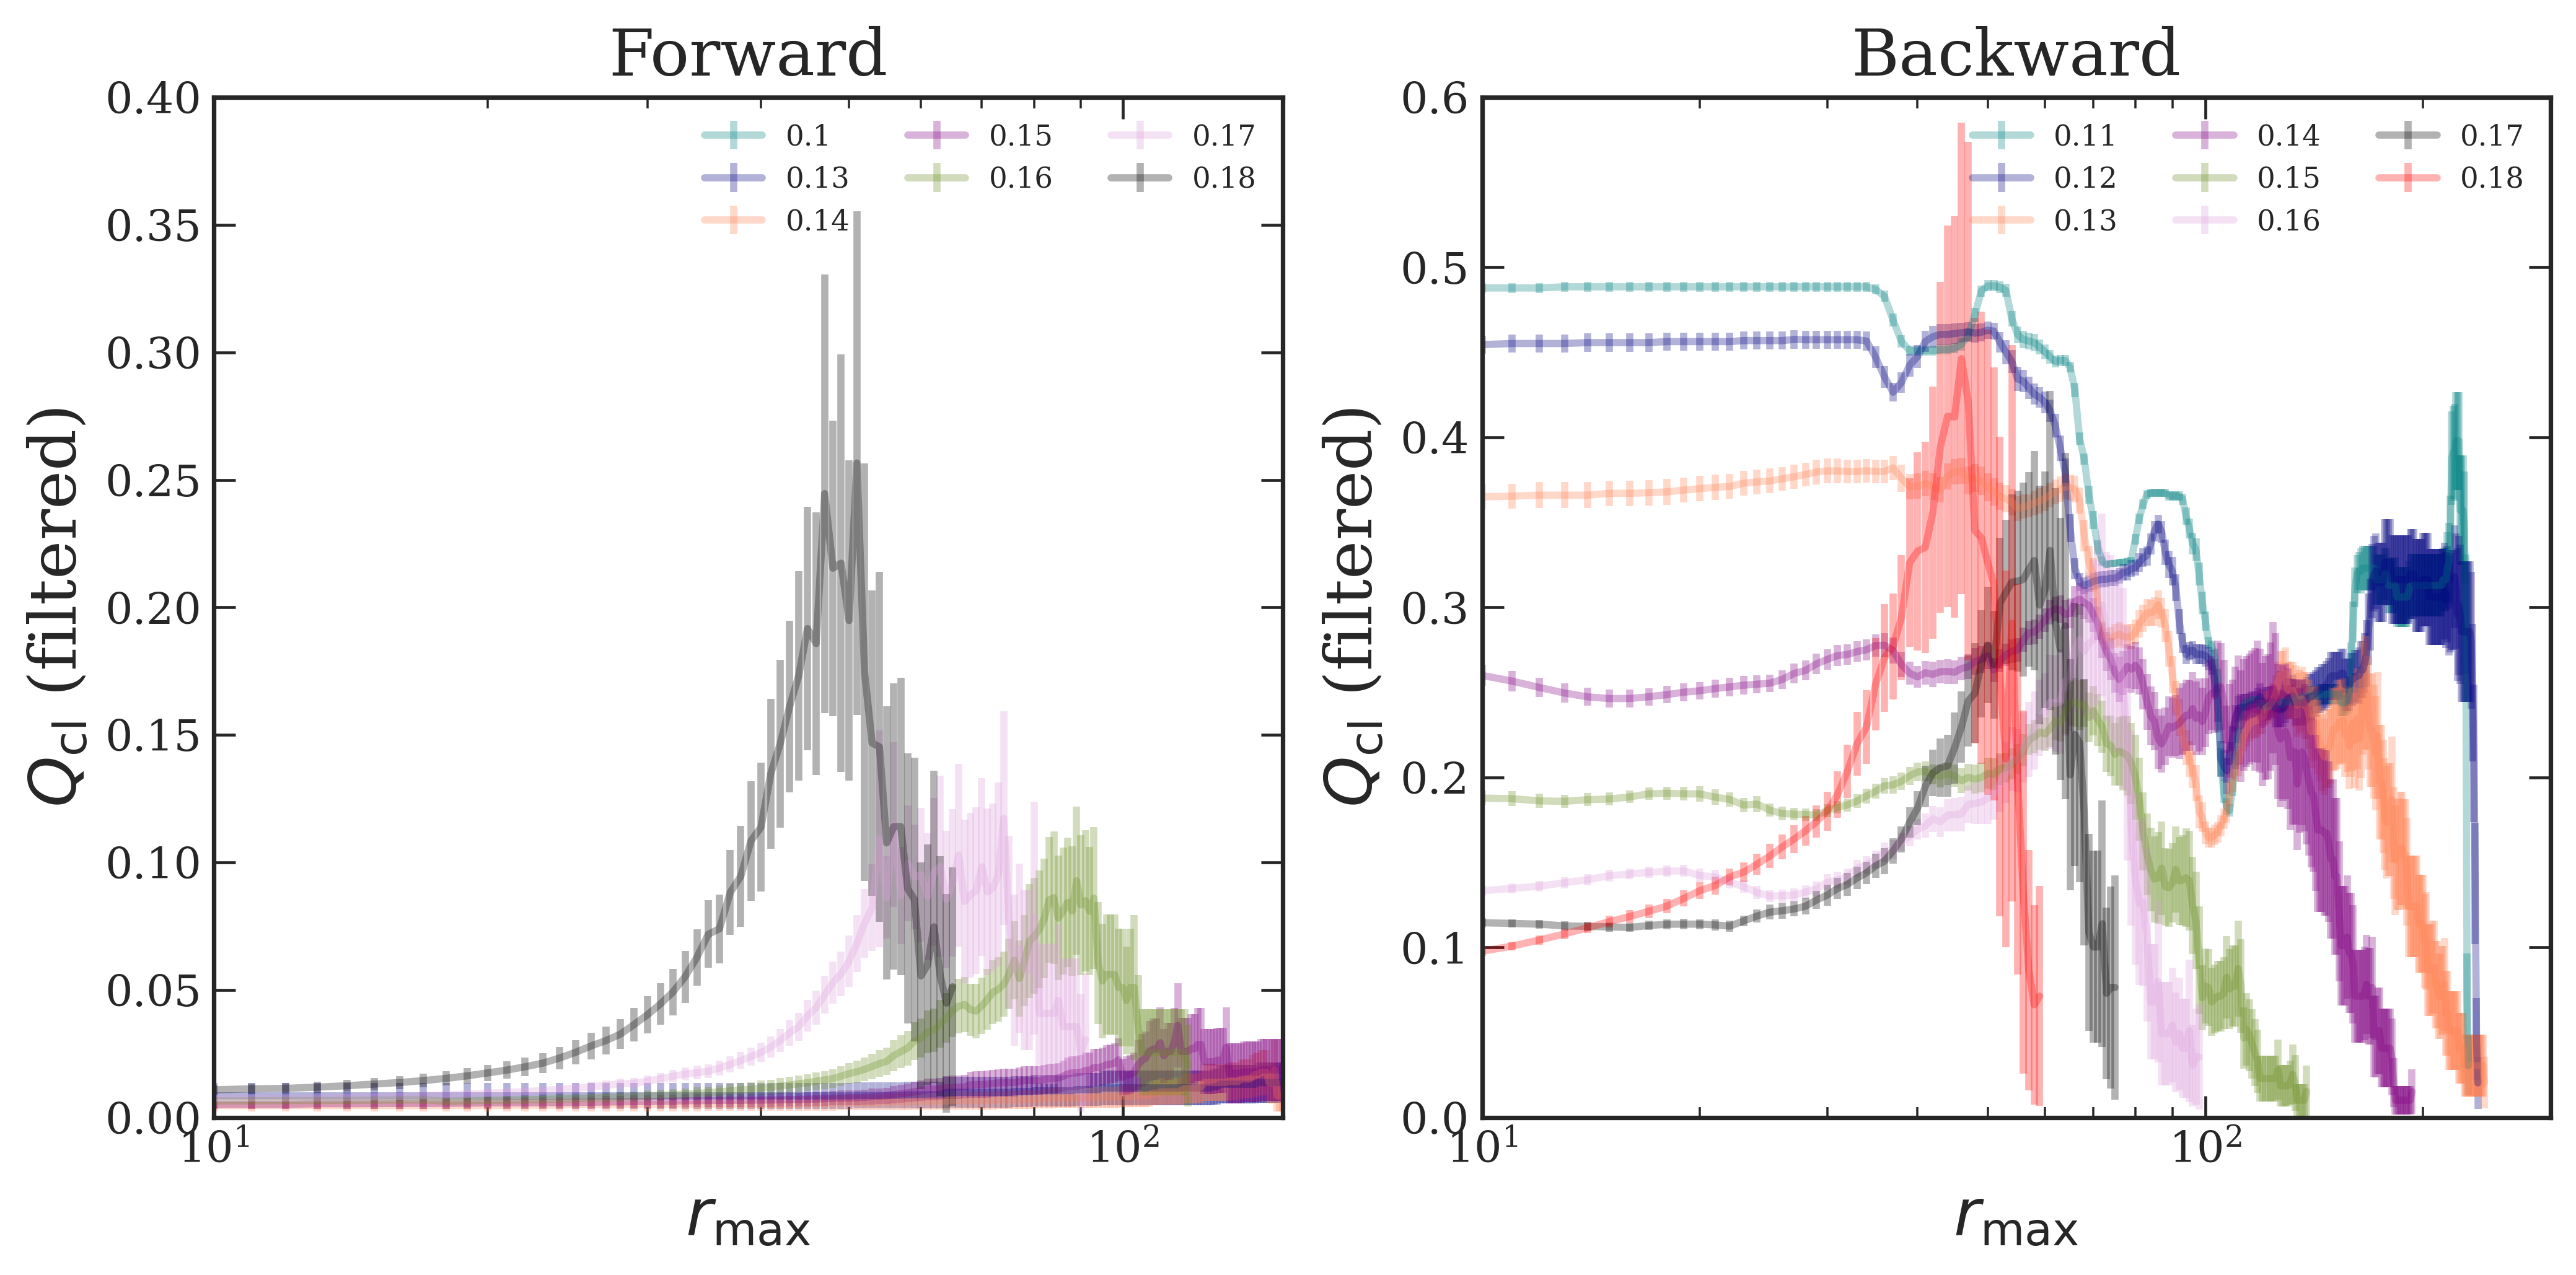

In [72]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

act_max = 0.18
act_max_res = 0.18

for i, act in enumerate(act_fwd):
    if act in [.007,.011]:
        continue
    if act > act_max:
        continue

    max_idx = np.argwhere(qfilter_fwd[i,:,0] - qfilter_fwd[i,:,1]<=0)[0][0] #int(np.max(idx_arr_fwd[ff_idx, i,]))
    ax[0].errorbar(rmax_list[:max_idx], qfilter_fwd[i,:max_idx,0], qfilter_fwd[i,:max_idx,1], label=f'{act}', alpha=.3)
    ax[0].title.set_text('Forward')



for i, act in enumerate(act_bck):
    if act in [0.007,.008]:
        continue
    if act > act_max:
        continue

    max_idx = np.argwhere(qfilter_bck[i,:,0] - qfilter_bck[i,:,1]<=0)[0][0] #int(np.max(idx_arr_fwd[ff_idx, i,]))
    ax[1].errorbar(rmax_list[:max_idx], qfilter_bck[i,:max_idx,0], qfilter_bck[i,:max_idx,1], label=f'{act}', alpha=.3)
    ax[1].title.set_text('Backward')


for a in ax:
    a.set_xscale('log')
    a.set_xlabel(r'$r_{\max}$')
    a.set_ylabel(r'$Q_{\mathrm{cl}}$ (filtered)')
    a.legend(ncols=3, fontsize=8)

ax[0].set_xlim(xmin=10, xmax=150)
ax[1].set_xlim(xmin=10, xmax=300)  
ax[0].set_ylim([0, .4])
ax[1].set_ylim([0, .6])    
fig.tight_layout()

if save_figs:
    fig.savefig(os.path.join(fig_path, f'qcl_filtered_{mode}{LX}.png'), bbox_inches = 'tight', dpi = 420)

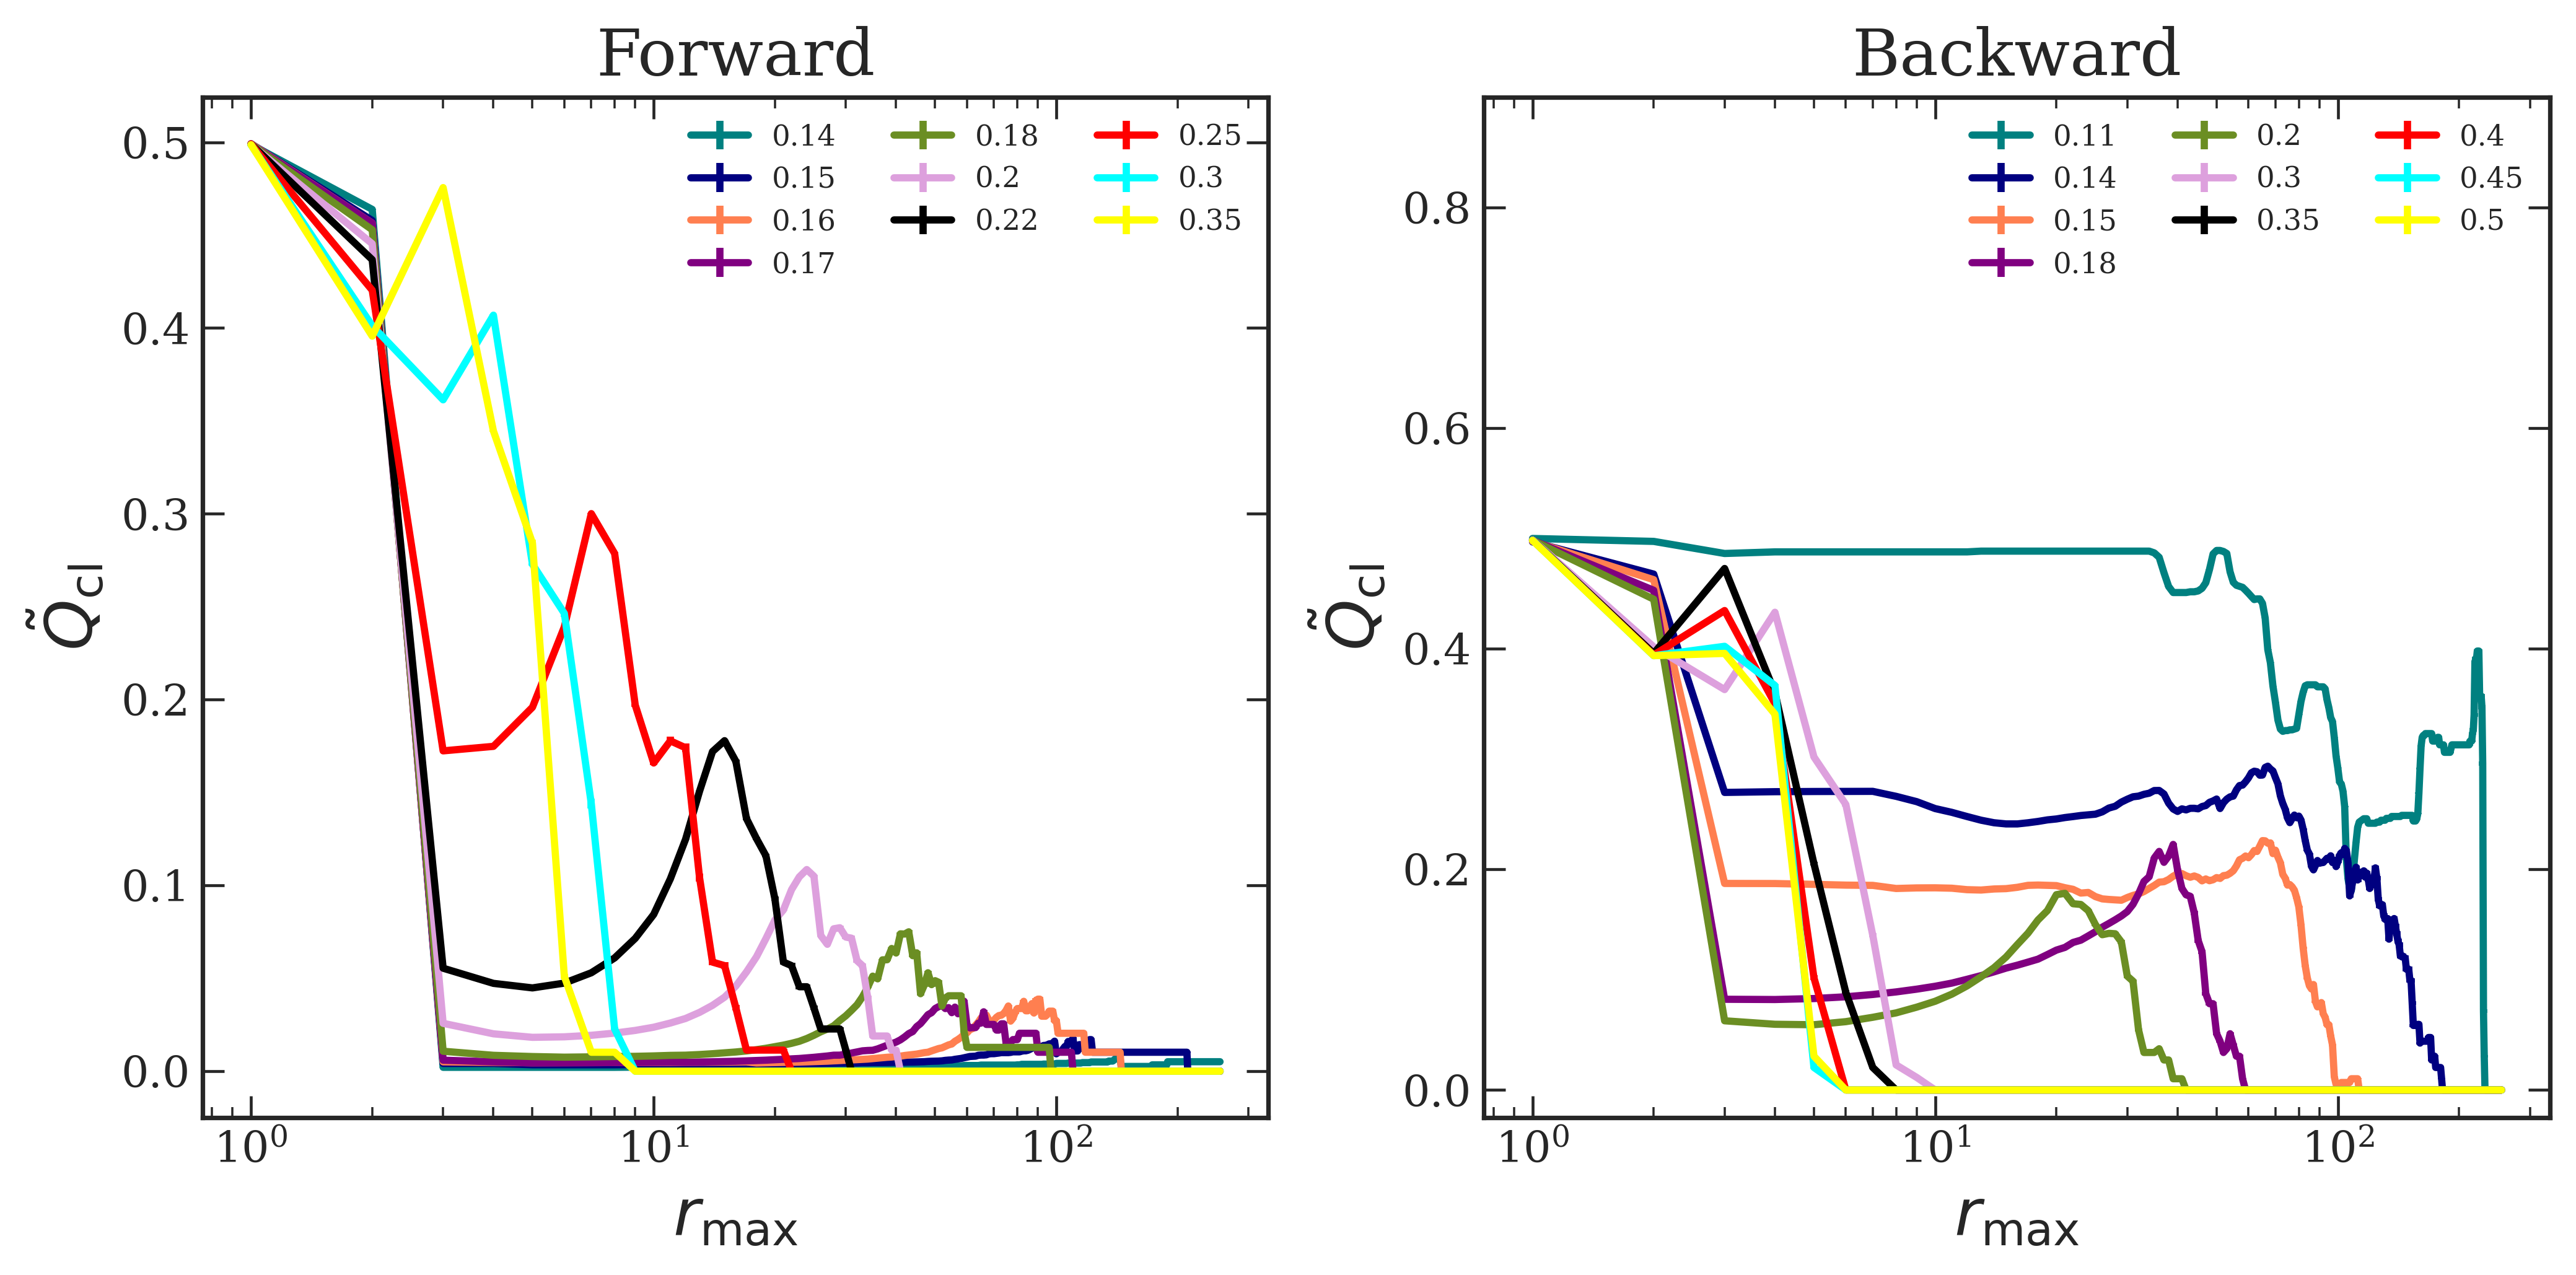

In [368]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))


for i, act in enumerate(act_fwd):
    if act in act_exclude_fwd:
        continue
    if act in [.011, .009]:
        continue

    ff_idx = int(conv_list_fwd[i])
    vals = qarr_shifted_fwd[ff_idx:, :, i,]

    qav = np.nanmean(vals, axis=(0,))
    qstd = np.nanstd(vals, axis=(0,)) \
    / np.sqrt((vals.size) / uncertainty_multiplier)

    ax[0].errorbar(rmax_list[:], qav, qstd, label=f'{act}')
    ax[0].title.set_text('Forward')

for i, act in enumerate(act_bck):
    if act in act_exclude_bck:
        continue
    if mode == 'dry' and act in [.25, .16, .13, .12, .17]:
        continue
    if mode == 'wet' and act in [.009, .011, .002, .005]:
        continue

    ff_idx = int(conv_list_bck[i])
    vals = qarr_shifted_bck[ff_idx:, :, i,]

    qav = np.nanmean(vals, axis=(0,))
    qstd = np.nanstd(vals, axis=(0,)) \
    / np.sqrt((vals.size) / uncertainty_multiplier)

    ax[1].errorbar(rmax_list[:], qav, qstd, label=f'{act}')
    ax[1].title.set_text('Backward')

for a in ax:
    a.set_xscale('log')
    a.set_xlabel(r'$r_{\max}$')
    a.set_ylabel(r'$\tilde{Q}_{\mathrm{cl}}$')
    a.legend(ncols=3, fontsize=8)

ax[1].set_ylim(ymax=.9)

fig.tight_layout()
if save_figs:
    fig.savefig(os.path.join(fig_path, f'qcl_shift_{mode}{LX}.png'), bbox_inches = 'tight', dpi = 420)

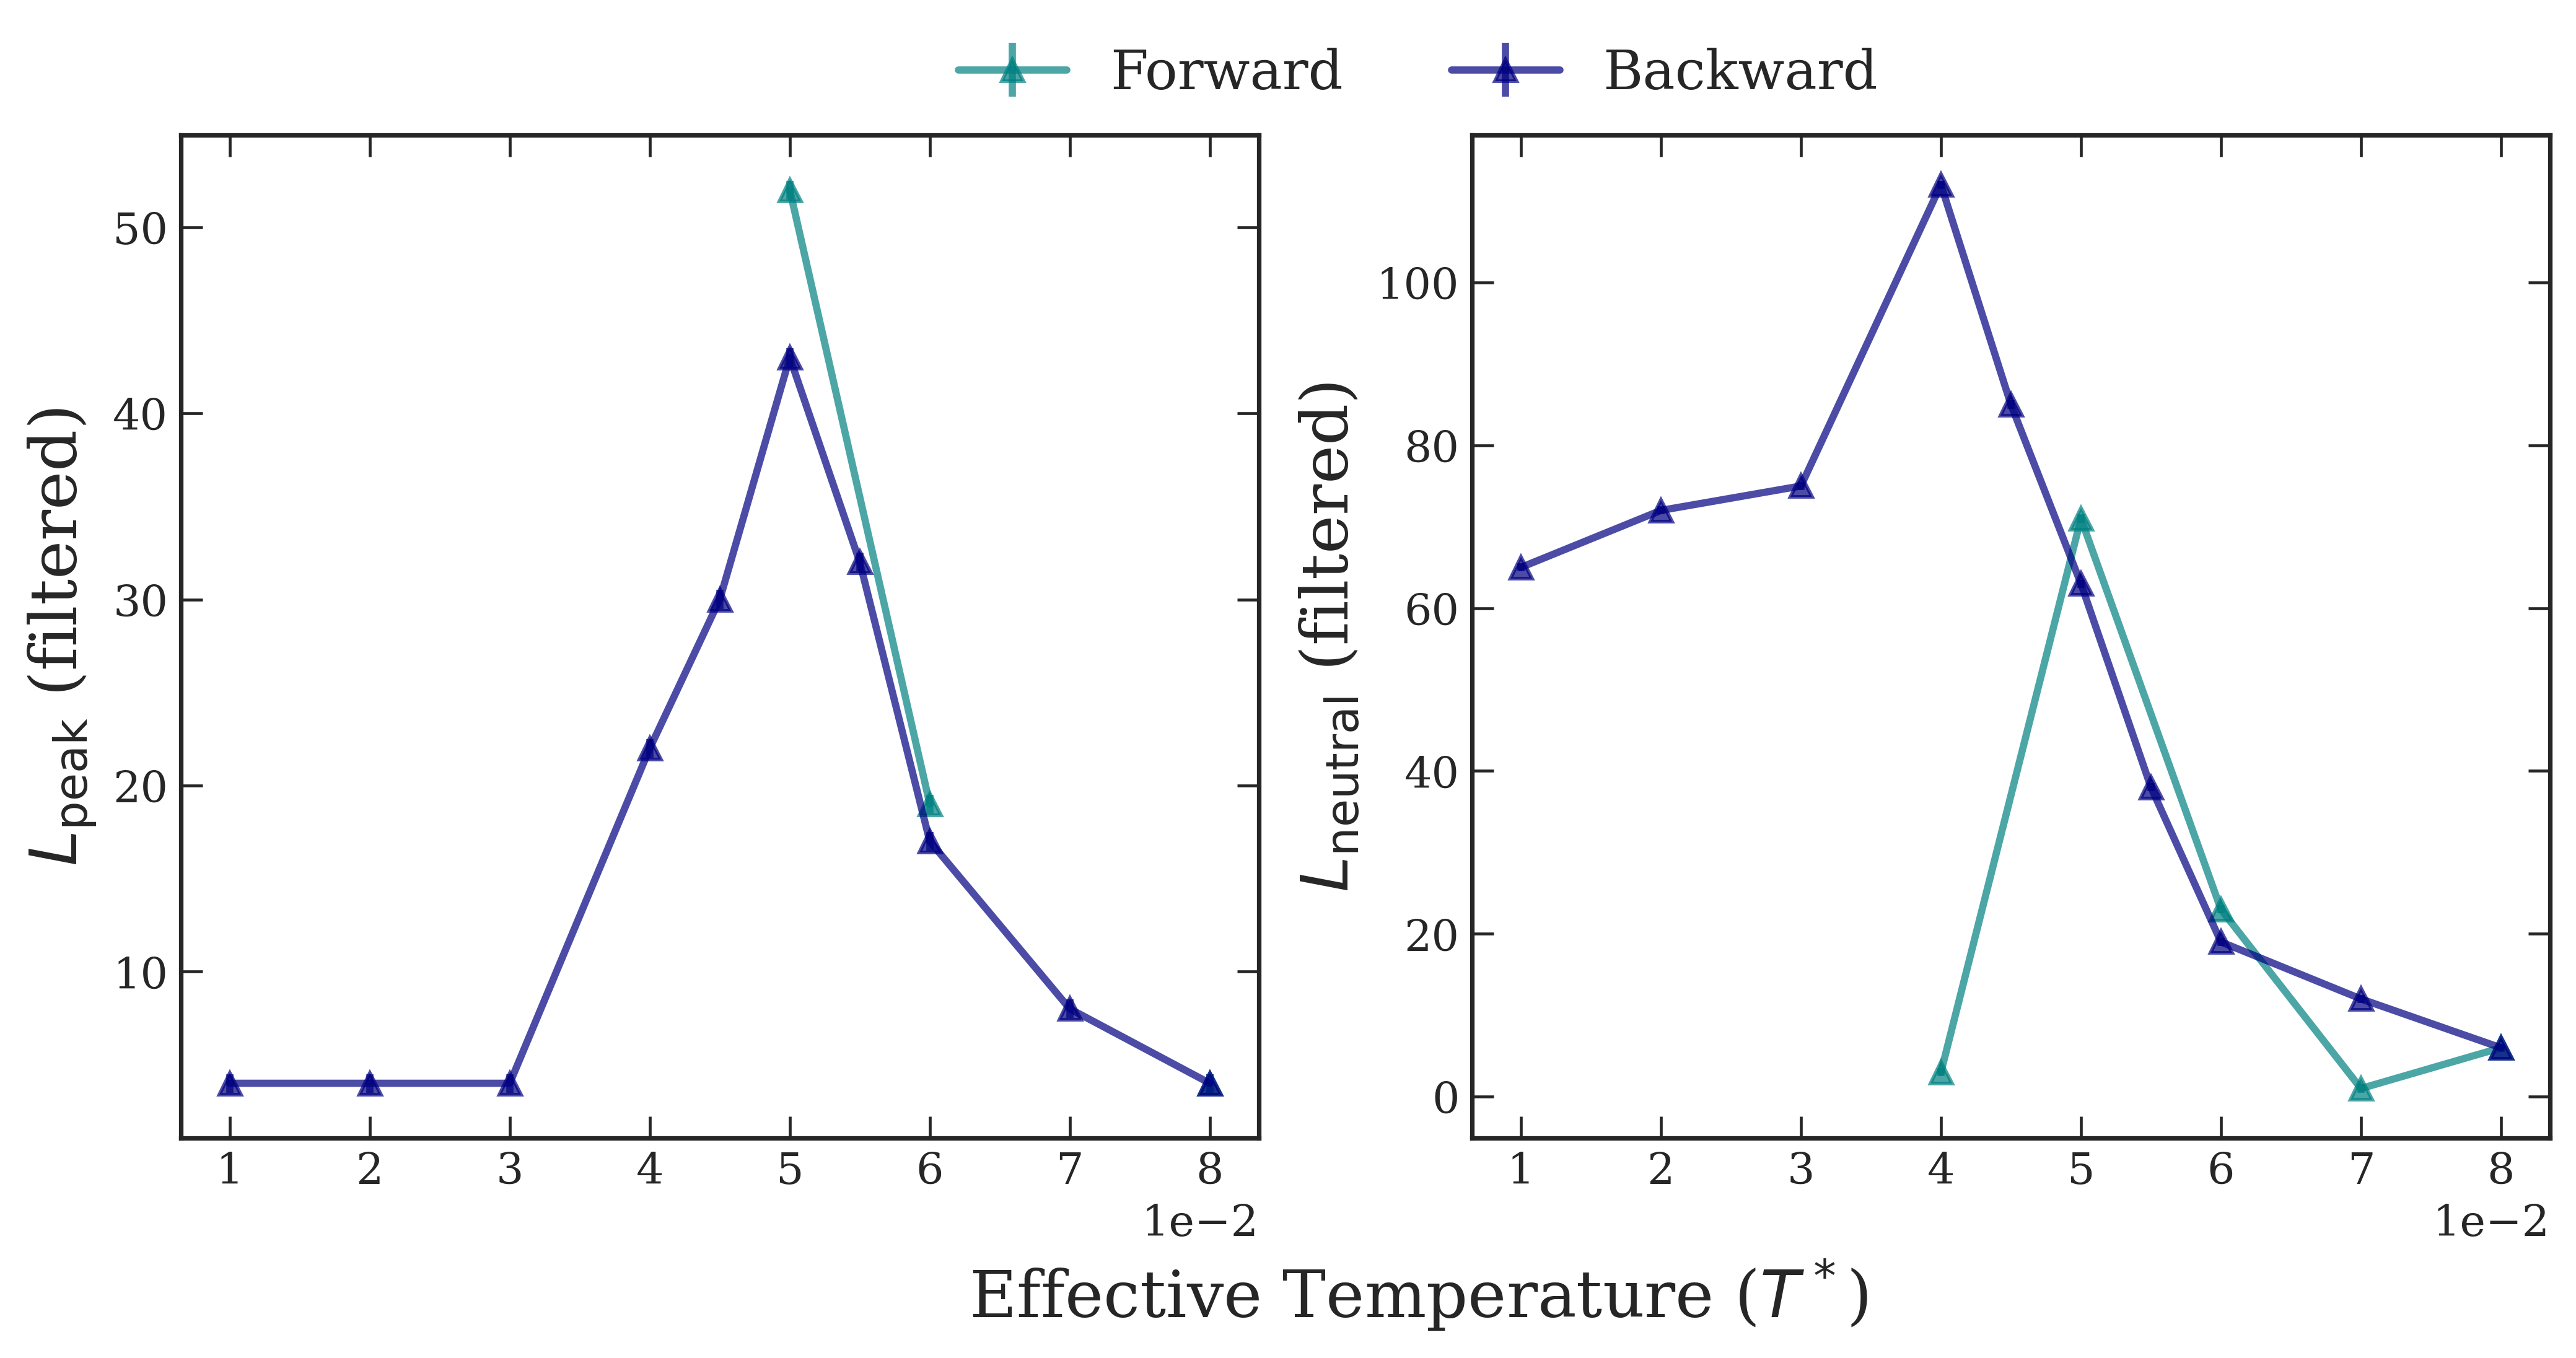

In [6]:
fig, ax = plt.subplots(ncols=2, figsize = (10, 5))

ax[0].errorbar(act_fwd, qpeak_filter_fwd[:, 0], yerr = qpeak_filter_fwd[:, 1],  fmt = '^-', alpha=.7, label = 'Forward')
ax[0].errorbar(act_bck, qpeak_filter_bck[:, 0], yerr = qpeak_filter_bck[:, 1], fmt = '^-', alpha=.7, label = 'Backward')
ax[0].set_ylabel(r'$L_{\mathrm{peak}}$ (filtered)')


ax[1].errorbar(act_fwd, lneutral_filter_fwd[:, 0], yerr = lneutral_filter_fwd[:, 1], fmt = '^-', alpha=.7)
ax[1].errorbar(act_bck, lneutral_filter_bck[:, 0], yerr = lneutral_filter_bck[:, 1], fmt = '^-', alpha=.7)
ax[1].set_ylabel(r'$L_{\mathrm{neutral}}$ (filtered)')

if mode == 'dry':
    ax[1].vlines(0.15, 0, 200, linestyle = '--', lw=1.5, color = 'k')
    ax[1].fill_betweenx([0,200], 0.145, 0.155, color = 'blue', alpha = 0.3)
    ax[1].text(0.16, 170, r'$T^{pf}_{\mathrm{KT}}(L_{\mathrm{neutral}}) \approx 0.15$', fontsize = 11)

fig.supxlabel(r'Effective Temperature ($T^*$)', x=0.55, y=0.05)
fig.legend(ncols=2, loc='upper center', bbox_to_anchor=(0.55, 1.075))      
fig.tight_layout()

if save_figs:
    fig.savefig(os.path.join(fig_path, f'qpeak_filtered_{mode}{LX}.png'), bbox_inches = 'tight', dpi = 420)

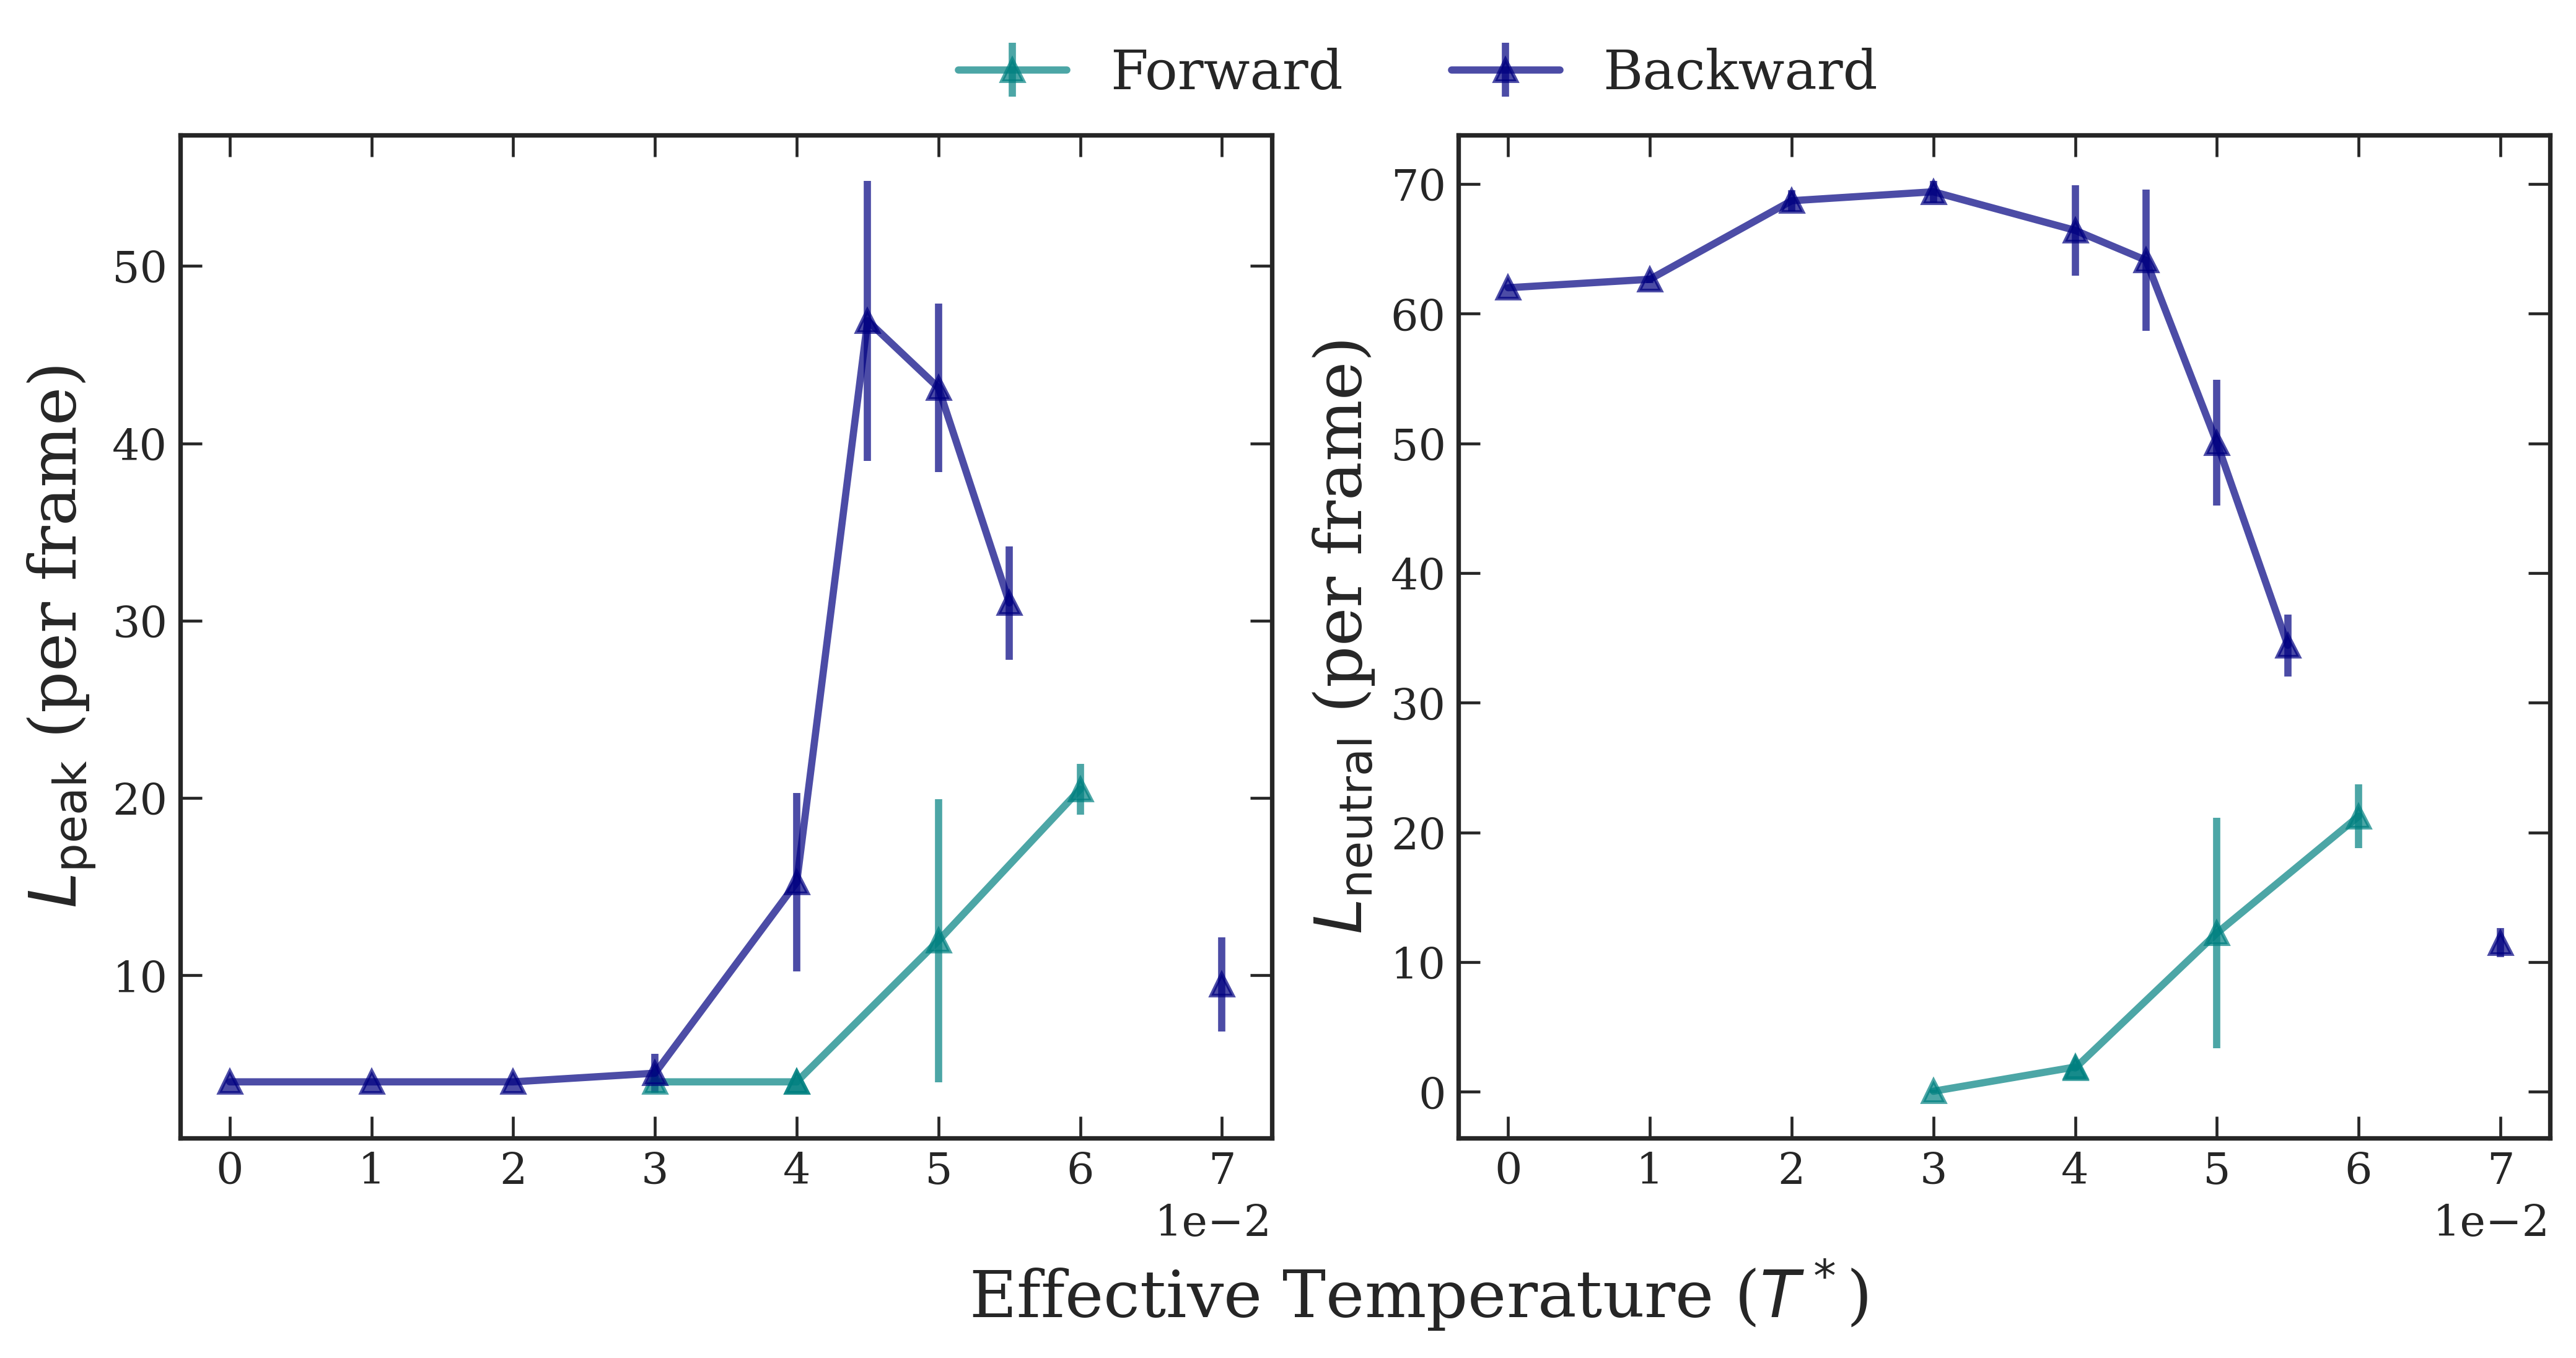

In [8]:
fig, ax = plt.subplots(ncols=2, figsize = (10, 5))

ax[0].errorbar(act_fwd, qpeak_per_frame_fwd[:, 0], yerr = qpeak_per_frame_fwd[:, 1],  fmt = '^-', alpha=.7, label = 'Forward')
ax[0].errorbar(act_bck, qpeak_per_frame_bck[:, 0], yerr = qpeak_per_frame_bck[:, 1], fmt = '^-', alpha=.7, label = 'Backward')
ax[0].set_ylabel(r'$L_{\mathrm{peak}}$ (per frame)')

ax[1].errorbar(act_fwd, lneutral_per_frame_fwd[:, 0], yerr = lneutral_per_frame_fwd[:, 1], fmt = '^-', alpha=.7)
ax[1].errorbar(act_bck, lneutral_per_frame_bck[:, 0], yerr = lneutral_per_frame_bck[:, 1], fmt = '^-', alpha=.7)
ax[1].set_ylabel(r'$L_{\mathrm{neutral}}$ (per frame)')

if mode == 'dry':
    ax[1].vlines(0.175, 0, 200, linestyle = '--', lw=1.5, color = 'k')
    ax[1].fill_betweenx([0,200], 0.16, 0.19, color = 'blue', alpha = 0.3)
    ax[1].text(0.2, 170, r'$T^{filtered}_{\mathrm{KT}}(L_{\mathrm{neutral}}) \approx 0.175$', fontsize = 11)

fig.supxlabel(r'Effective Temperature ($T^*$)', x=0.55, y=0.05)
fig.legend(ncols=2, loc='upper center', bbox_to_anchor=(0.55, 1.075))      
fig.tight_layout()

if save_figs:
    fig.savefig(os.path.join(fig_path, f'qpeak_lneutral_per_frame_{mode}{LX}.png'), bbox_inches = 'tight', dpi = 420)

_filter
_filter
_filter
_filter


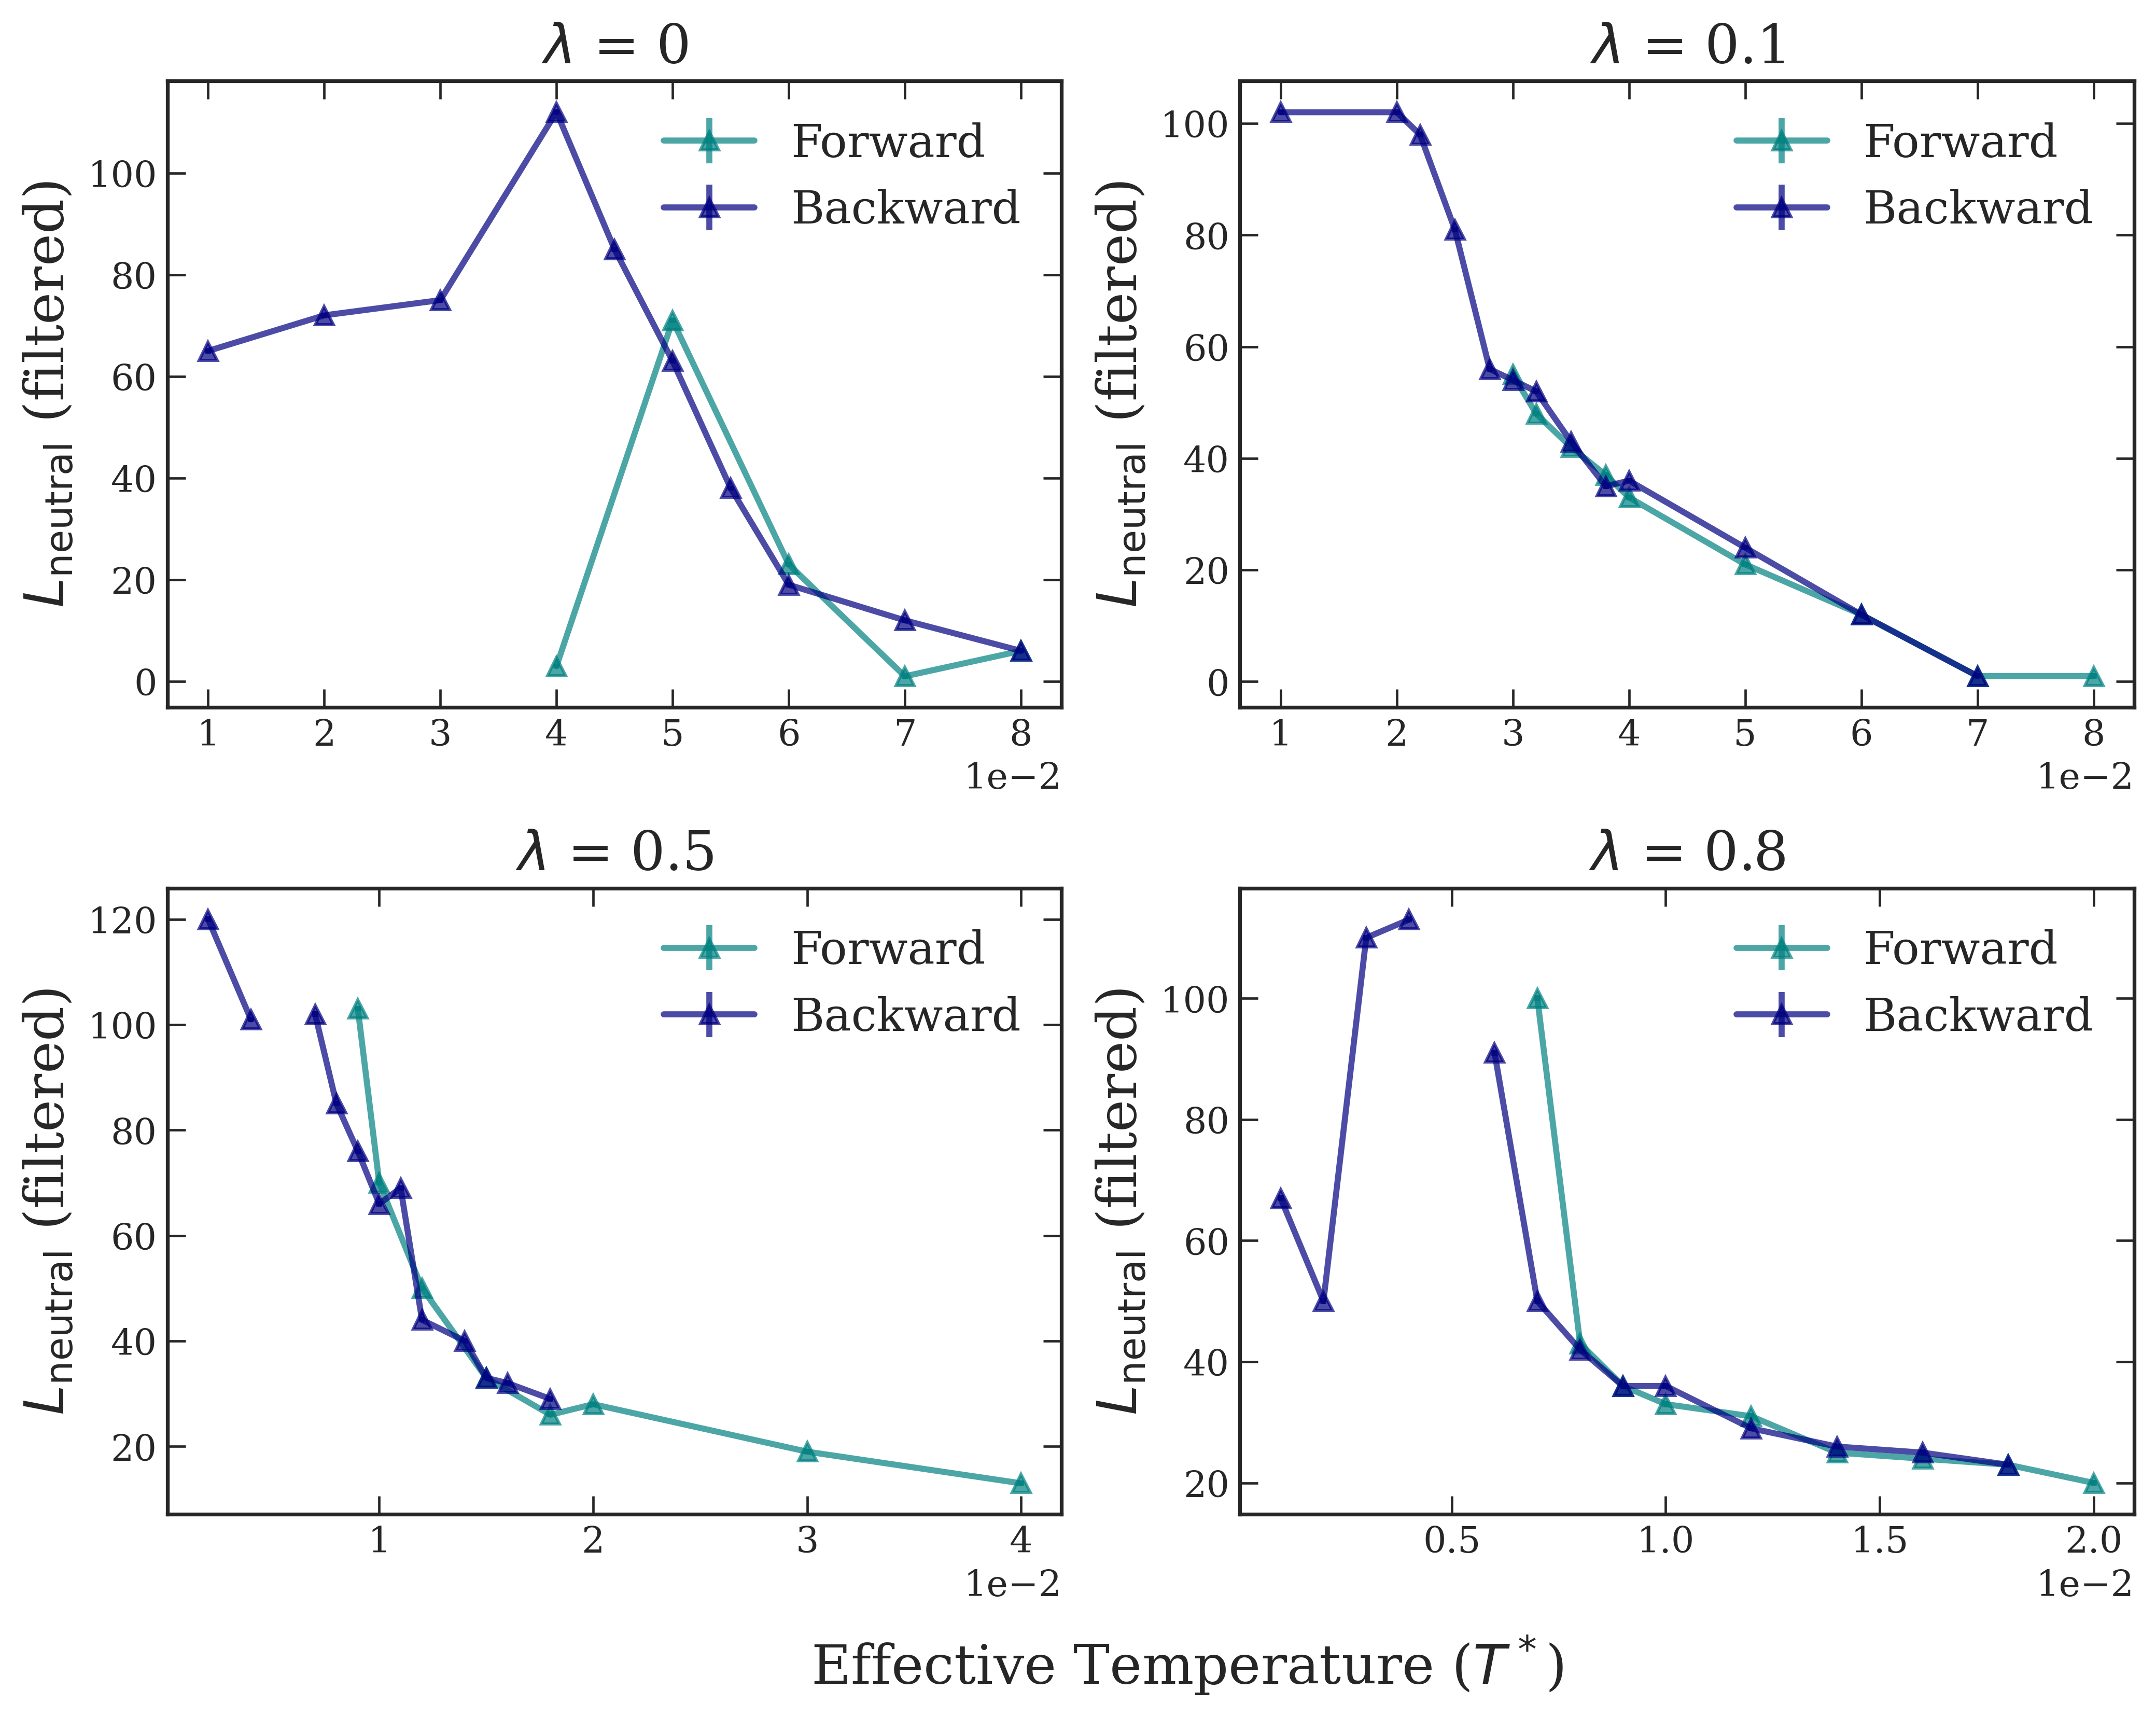

In [14]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize = (10, 8))
ax = ax.flatten()
LX = 256
mode = 'wet'
suffix = '_filter'

lambda_list = [0, 0.1, 0.5, 0.8]

extract = False
find_conv = False
analyze= True
analyze_per_frame = True #if mode == 'dry' else False
plot_figs = True
save_figs = True

for ll, lambda_val in enumerate(lambda_list):
    base_path_fwd = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\jayeeta\\diff_lambda\\{mode}\\na{LX}\\{lambda_val}\\fwd'
    base_path_bck = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\jayeeta\\diff_lambda\\{mode}\\na{LX}\\{lambda_val}\\bck'
    out_path = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda\\{mode}\\na{LX}\\{lambda_val}'
    fig_path = os.path.join(out_path, 'figs')

    if not os.path.isdir(fig_path):
        os.makedirs(fig_path)
    if not os.path.isdir(out_path):
        os.makedirs(out_path)

    act_dirs_fwd = [os.path.join(base_path_fwd, x) for x in os.listdir(base_path_fwd)]
    act_dirs_bck = [os.path.join(base_path_bck, x) for x in os.listdir(base_path_bck)] 

    act_fwd = [float(x.split('-')[-2]) for x in os.listdir(base_path_fwd)]
    act_bck = [float(x.split('-')[-2]) for x in os.listdir(base_path_bck)]

    act_exclude_fwd = []
    act_exclude_bck = []

    Nact_fwd = len(act_fwd)
    Nact_bck = len(act_bck)

    rmax_list = np.arange(10, LX / 2) if mode == 'wet' and LX==512 else np.arange(1, LX / 2,)
    Nframes = 51
    Nwindows = len(rmax_list)
    ninfo = 1000

    cluster_dict_fwd = dict(LX = LX, Nframes = Nframes, Nact = len(act_fwd), Nwindows = len(rmax_list), path = out_path, suffix = '_fwd')
    cluster_dict_bck = dict(LX = LX, Nframes = Nframes, Nact = len(act_bck), Nwindows = len(rmax_list), path = out_path, suffix = '_bck')
    print(suffix)
    qpeak_fwd = np.load(os.path.join(out_path, f'qpeak{suffix}_fwd.npy'))
    qpeak_bck = np.load(os.path.join(out_path, f'qpeak{suffix}_bck.npy'))
    lneutral_fwd = np.load(os.path.join(out_path, f'lneutral{suffix}_fwd.npy'))
    lneutral_bck = np.load(os.path.join(out_path, f'lneutral{suffix}_bck.npy'))

    ax[ll].errorbar(act_fwd, lneutral_fwd[:, 0], 
                    yerr = lneutral_fwd[:, 1], fmt = '^-', alpha=.7, label = 'Forward')
    ax[ll].errorbar(act_bck, lneutral_bck[:, 0], 
                    yerr = lneutral_bck[:, 1], fmt = '^-', alpha=.7, label = 'Backward')
    ylabel_name = r'$L_{\mathrm{neutral}}$ (filtered)' if suffix == '_filter' else r'$L_{\mathrm{neutral}}$'
    ax[ll].set_ylabel(ylabel_name)
    ax[ll].set_title(rf'$\lambda$ = {lambda_val}')
    ax[ll].legend()

    if mode == 'dry':
        ax[ll].vlines(0.15, 0, 250, linestyle = '--', lw=1.5, color = 'k')
        ax[ll].fill_betweenx([0,200], 0.14, 0.16, color = 'blue', alpha = 0.3)
        ax[ll].text(0.18, 170, r'$T^{shift}_{\mathrm{KT}}(L_{\mathrm{neutral}}) \approx 0.15$', fontsize = 11)

fig.supxlabel(r'Effective Temperature ($T^*$)', x=0.55, y=0.02)
#fig.legend(ncols=2, loc='upper center', bbox_to_anchor=(0.55, 1.075))      
fig.tight_layout();

if save_figs:
   fig.savefig(os.path.join(fig_path, f'qpeak_lneutral_{mode}{LX}.png'), bbox_inches = 'tight', dpi = 420)

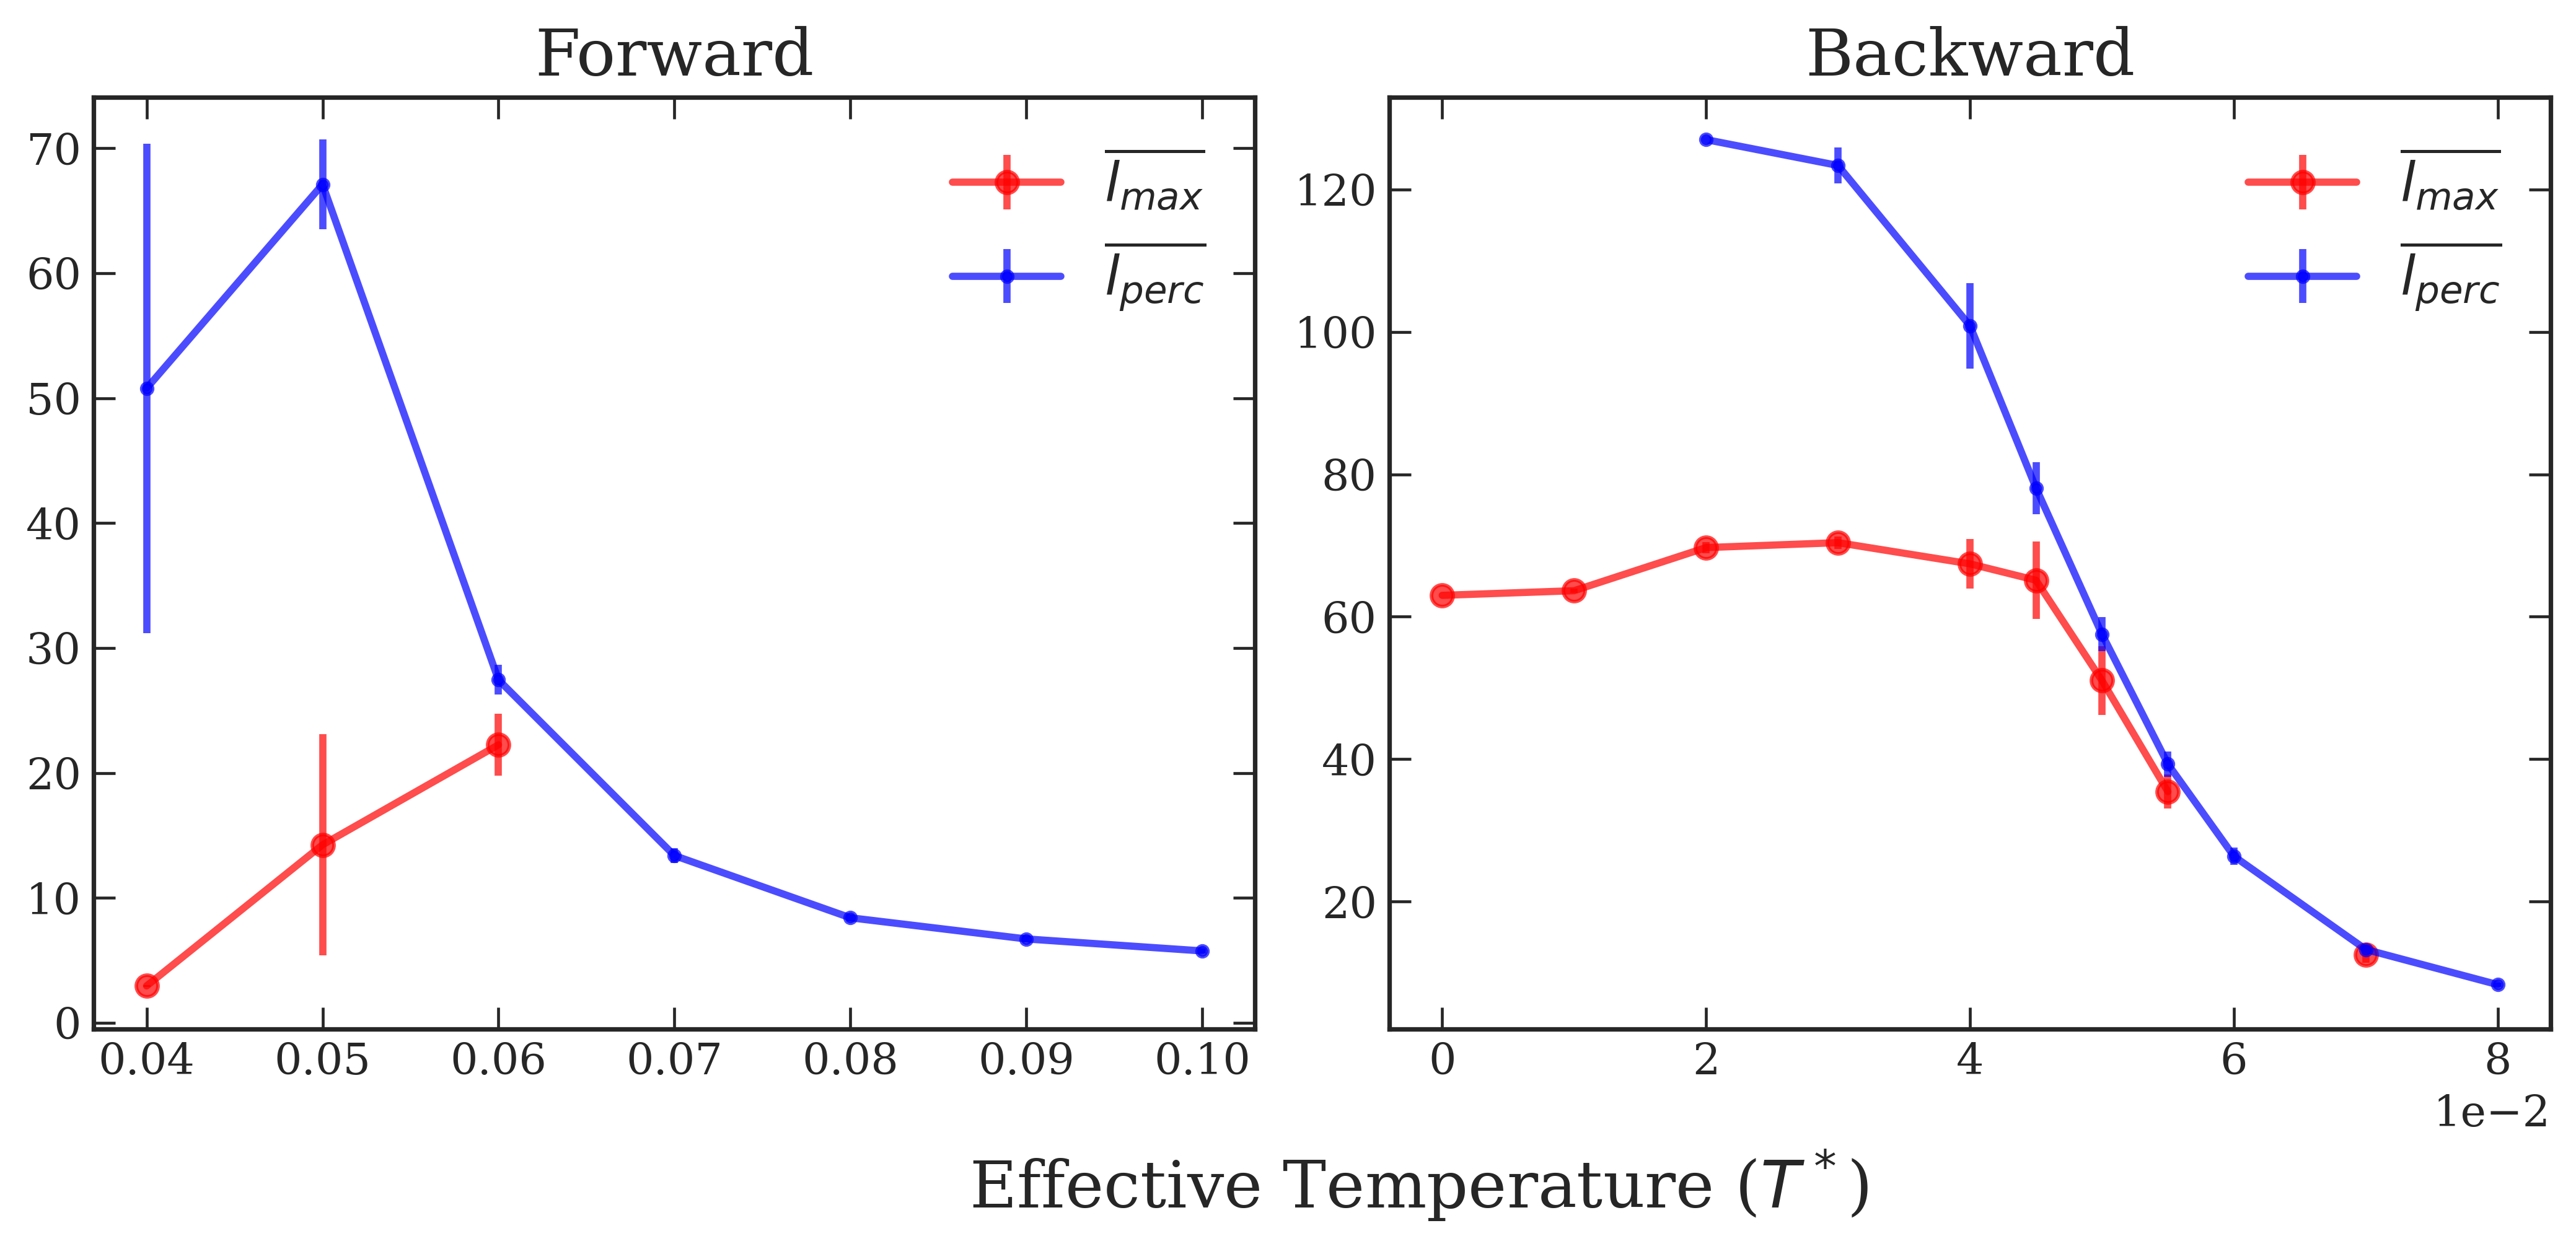

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))


ax[0].errorbar(act_fwd, lmax_av_fwd[:,0], yerr=lmax_av_fwd[:,1], alpha=.7,fmt='ro-', label=r'$\overline{l_{max}}$')
ax[0].errorbar(act_fwd[1:], lperc_av_fwd[1:,0], yerr=lperc_av_fwd[1:,1], alpha=.7, fmt='b.-', label=r'$\overline{l_{perc}}$')
ax[0].title.set_text('Forward')
ax[0].legend()  

ax[1].errorbar(act_bck, lmax_av_bck[:,0], yerr=lmax_av_bck[:,1], alpha=.7, fmt='ro-', label=r'$\overline{l_{max}}$')
ax[1].errorbar(act_bck, lperc_av_bck[:,0], yerr=lperc_av_bck[:,1], alpha=.7, fmt='b.-', label=r'$\overline{l_{perc}}$')
ax[1].title.set_text('Backward')
ax[1].legend()

if mode == 'dry':
   # ax[0].vlines(0.175, 0, 200, linestyle = '--', lw=1.5, color = 'k')
   # ax[0].fill_betweenx([0,200], 0.165, 0.185, color = 'green', alpha = 0.3)
   # ax[0].text(0.135, 200, r'$T_{\mathrm{KT}}(\overline{l_{max}})$', fontsize = 11)


    #ax[0].vlines(0.018, 0, 850, linestyle = '-.', lw=1.5, color = 'k')
    #ax.fill_betweenx([0,850], 0.0175, 0.0185, color = 'gray', alpha = 0.5)
    ax[0].set_ylim(ymax=220)
    ax[0].vlines(0.19, 0, 200, linestyle = '--', lw=1.5, color = 'k')
    ax[0].fill_betweenx([0,200], 0.18, 0.2, color = 'blue', alpha = 0.3)
    ax[0].text(0.205, 170, r'$T_{\mathrm{CV}} \approx 0.19$', fontsize = 11)
    #x.text(0.19,  100, r'$\zeta_{\mathrm{nucleation}}$', fontsize = 11)

fig.supxlabel(r'Effective Temperature ($T^*$)', x=0.55, y=0.05)

if save_figs:
    fig.savefig(os.path.join(fig_path, f'lmax_lperc_{mode}{LX}.png'), bbox_inches = 'tight', dpi = 420)